In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import networkx as nx
from networkx.algorithms import bipartite
from NodeSizeScaler import NodeSizeScaler
from NetworkProperties import NetworkProperties
import community
from communities.LouvainMethod import LouvainMethod
from communities.HierarchicalClustering import HierarchicalClustering

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from itertools import combinations, permutations
from collections import Counter
from iteration_utilities import unique_everseen, chained

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('datasets/NS_senators.csv')
df['uniquebill'] = df[['congress', 'bill_num']].astype(str).agg('-'.join, axis=1)
df

congress    type  bill_num  \
0            13  Senate         1   
1            13  Senate         2   
2            13  Senate         3   
3            13  Senate         4   
4            13  Senate         5   
...         ...     ...       ...   
15622        18  Senate      2120   
15623        18  Senate      2121   
15624        18  Senate      2122   
15625        18  Senate      2123   
15626        18  Senate      2124   

                                                   title        filed_on  \
0         SPECIAL MEASURES TO LOWER THE COST OF MEDICINE       30-Jun-04   
1                      THE CONSTITUTIONAL CONVENTION ACT       30-Jun-04   
2        MAGNA CARTA OF PATIENT'S RIGHTS AND OBLIGATIONS       30-Jun-04   
3                           HEALTH PROMOTION ACT OF 2004       30-Jun-04   
4      INCREASING THE ALLOWABLE PERSONAL ADDITIONAL T...       30-Jun-04   
...                                                  ...             ...   
15622      ILOCOS SUR PHILIPPINES POLYTECHNIC UNIVERSITY  March 24, 2021   
15623                                        RED-TAGGING  March 24, 2021   
15624  THE 30-YEAR NATIONAL INFRASTRUCTURE MASTER PLA...  March 24, 2021   
15625              EXPANDED STIMULUS PACKAGE ACT OF 2021  March 24, 2021   
15626       AMENDING THE SANGGUNIANG KABATAAN REFORM ACT  March 24, 2021   

                                                filed_by  \
0                   Flavier, Juan M., Angara, Edgardo J.   
1                                       Flavier, Juan M.   
2                   Flavier, Juan M., Angara, Edgardo J.   
3                   Flavier, Juan M., Angara, Edgardo J.   
4                                       Flavier, Juan M.   
...                                                  ...   
15622                                    Marcos, Imee R.   
15623                                Drilon, Franklin M.   
15624                      Pacquiao, Emmanuel "Manny" D.   
15625                      Pacquiao, Emmanuel "Manny" D.   
15626  Angara, Sonny, Revilla Jr., Ramon Bong, Marcos...   

                                              long_title     scope  \
0      AN ACT PRESCRIBING SPECIAL  MEASURES  TO LOWER...  National   
1      AN ACT CALLING FOR A  CONSTITUTIONAL CONVENTIO...  National   
2      AN ACT DECLARING THE RIGHTS  AND OBLIGATIONS O...  National   
3      AN ACT ESTABLISHING A  NATIONAL HEALTH PROMOTI...  National   
4      AN ACT INCREASING THE ALLOWABLE PERSONAL ADDIT...  National   
...                                                  ...       ...   
15622  AN ACT CONVERTING THE ILOCOS SUR POLYTECHNIC S...     Local   
15623  AN ACT DEFINING AND PENALIZING THE CRIME OF RE...  National   
15624  AN ACT ADOPTING A 30-YEAR NATIONAL INFRASTRUCT...  National   
15625  AN ACT AUGMENTING THE STIMULUS PACKAGE FOR COV...  National   
15626  AN ACT TO FURTHER EMPOWER THE MEMBERS OF THE S...  National   

                                                subjects  \
0      Medicines (Lowering the Cost)           Drugs/...   
1      Constitutional Convention               Charte...   
2      Patients Rights and Obligations         Magna ...   
3      National Health Promotion Institute     Philip...   
4      Taxes (Tax Exemption-Individual TaxpayerNation...   
...                                                  ...   
15622                                Schools, Conversion   
15623                            Red-Tagging/Red-Baiting   
15624                                    Infrastructures   
15625                                           Covid-19   
15626                     Sangguniang Kabataan (SK)Youth   

                                       primary_committee  \
0                                  Health and Demography   
1      Constitutional Amendments, Revision of Codes a...   
2                                  Health and Demography   
3         Government Corporations and Public Enterprises   
4                                         Ways and Means   
...   

In [246]:
df.status.unique()

array(['Pending in the Committee',
       'Consolidated/Substituted in the Committee Report',
       'Approved on Third Reading by the Senate',
       'Approved by the President of the Philippines',
       'Conference Committee Report Approved by Senate',
       'Consolidated with Approved Bill', 'Pending Conference Committee',
       'Pending Second Reading, Special Order',
       'Pending in the House of Representatives', 'Lapsed Into Law',
       'Pending Second Reading, Ordinary Business',
       'Sent to the Archives', 'Withdrawn',
       'Vetoed by the President of the Philippines',
       'Recommitted to the Committee',
       'Approved on  Second Reading, with Amendments',
       'Committee Report Sent to the Archives',
       'Approved on Second Reading, Without Amendment',
       'Enrolled Copy Sent to Malacanang',
       'With Senate Designated Conferees', 'Passed by Both Houses', nan],
      dtype=object)

In [3]:
len(df)

15627

In [4]:
sen = ', '.join(df.filed_by.unique().tolist()).split(', ')
sen1 = set([i+', '+j for i, j in zip(sen[::2], sen[1::2])])
sen2 = set([i+'; '+j for i, j in zip(sen[::2], sen[1::2])])

for i, j in zip(sorted(sen1), sorted(sen2)):
    df['filed_by'] = df.filed_by.str.replace(i, j)
    
df['filed_by'] = df.filed_by.str.replace("Angara; Sonny", """Angara; Juan Edgardo "Sonny" M.""")
df['filed_by'] = df.filed_by.str.replace("""Cayetano; Alan Peter "Companero" S.""", "Cayetano; Alan Peter Companero S.")
df['filed_by'] = df.filed_by.str.replace("""Cayetano; "Companera" Pia S.""", "Cayetano; Pia S.")
df['filed_by'] = df.filed_by.str.replace("Cayetano; Companera Pia S.", "Cayetano; Pia S.")
df['filed_by'] = df.filed_by.str.replace("Hontiveros; Risa L.", "Hontiveros; Risa")
df['filed_by'] = df.filed_by.str.replace("""Lacson; Panfilo "Ping" M.""", "Lacson; Panfilo M.")
df['filed_by'] = df.filed_by.str.replace("""Pangilinan; Francis "Kiko" N.""", "Pangilinan; Francis N.")
df['filed_by'] = df.filed_by.str.replace("Pimentel; Aquilino Koko III L.", """Pimentel; Aquilino "Koko" III""")
df['filed_by'] = df.filed_by.str.replace("Poe; Grace L.", "Poe; Grace")
df['filed_by'] = df.filed_by.str.replace("""Trillanes IV; Antonio "Sonny" F.""", """Trillanes; Antonio "Sonny" F.""")
df['filed_by'] = df.filed_by.str.replace("""Zubiri; Juan Miguel "Migz" F.""", "Zubiri; Juan Miguel F.")
df['filed_by'] = df.filed_by.str.replace("Villar; Manny B.", "Villar; Manny")
df['filed_by'] = df.filed_by.str.replace("""Gordon; Richard "Dick" J.""", "Gordon; Richard J.")
df['filed_by'] = df.filed_by.str.replace("""Gatchalian; Sherwin T.""", "Gatchalian; Win")
df['filed_by'] = df.filed_by.str.replace("""Revilla Jr.; Ramon A.""", "Revilla Jr.; Ramon Bong")
df['filed_by'] = df.filed_by.str.replace("""Villar Jr.; Manuel B.""", "Villar; Manny")

In [5]:
df['filed_by'] = df.filed_by.str.split(', ')
df['filed_by2'] = df.filed_by

In [6]:
df2 = df.explode('filed_by')
df2

congress    type  bill_num  \
0            13  Senate         1   
0            13  Senate         1   
1            13  Senate         2   
2            13  Senate         3   
2            13  Senate         3   
...         ...     ...       ...   
15624        18  Senate      2122   
15625        18  Senate      2123   
15626        18  Senate      2124   
15626        18  Senate      2124   
15626        18  Senate      2124   

                                                   title        filed_on  \
0         SPECIAL MEASURES TO LOWER THE COST OF MEDICINE       30-Jun-04   
0         SPECIAL MEASURES TO LOWER THE COST OF MEDICINE       30-Jun-04   
1                      THE CONSTITUTIONAL CONVENTION ACT       30-Jun-04   
2        MAGNA CARTA OF PATIENT'S RIGHTS AND OBLIGATIONS       30-Jun-04   
2        MAGNA CARTA OF PATIENT'S RIGHTS AND OBLIGATIONS       30-Jun-04   
...                                                  ...             ...   
15624  THE 30-YEAR NATIONAL INFRASTRUCTURE MASTER PLA...  March 24, 2021   
15625              EXPANDED STIMULUS PACKAGE ACT OF 2021  March 24, 2021   
15626       AMENDING THE SANGGUNIANG KABATAAN REFORM ACT  March 24, 2021   
15626       AMENDING THE SANGGUNIANG KABATAAN REFORM ACT  March 24, 2021   
15626       AMENDING THE SANGGUNIANG KABATAAN REFORM ACT  March 24, 2021   

                              filed_by  \
0                     Flavier; Juan M.   
0                   Angara; Edgardo J.   
1                     Flavier; Juan M.   
2                     Flavier; Juan M.   
2                   Angara; Edgardo J.   
...                                ...   
15624    Pacquiao; Emmanuel "Manny" D.   
15625    Pacquiao; Emmanuel "Manny" D.   
15626  Angara; Juan Edgardo "Sonny" M.   
15626          Revilla Jr.; Ramon Bong   
15626                  Marcos; Imee R.   

                                              long_title     scope  \
0      AN ACT PRESCRIBING SPECIAL  MEASURES  TO LOWER...  National   
0      AN ACT PRESCRIBING SPECIAL  MEASURES  TO LOWER...  National   
1      AN ACT CALLING FOR A  CONSTITUTIONAL CONVENTIO...  National   
2      AN ACT DECLARING THE RIGHTS  AND OBLIGATIONS O...  National   
2      AN ACT DECLARING THE RIGHTS  AND OBLIGATIONS O...  National   
...                                                  ...       ...   
15624  AN ACT ADOPTING A 30-YEAR NATIONAL INFRASTRUCT...  National   
15625  AN ACT AUGMENTING THE STIMULUS PACKAGE FOR COV...  National   
15626  AN ACT TO FURTHER EMPOWER THE MEMBERS OF THE S...  National   
15626  AN ACT TO FURTHER EMPOWER THE MEMBERS OF THE S...  National   
15626  AN ACT TO FURTHER EMPOWER THE MEMBERS OF THE S...  National   

                                                subjects  \
0      Medicines (Lowering the Cost)           Drugs/...   
0      Medicines (Lowering the Cost)           Drugs/...   
1      Constitutional Convention               Charte...   
2      Patients Rights and Obligations         Magna ...   
2      Patients Rights and Obligations         Magna ...   
...                                                  ...   
15624                                    Infrastructures   
15625                                           Covid-19   
15626                     Sangguniang Kabataan (SK)Youth   
15626                     Sangguniang Kabataan (SK)Youth   
15626                     Sangguniang Kabataan (SK)Youth   

                                       primary_committee  \
0                                  Health and Demography   
0                                  Health and Demography   
1      Constitutional Amendments, Revision of Codes a...   
2                                  Health and Demography   
2                                  Health and Demography   
...                                                  ...   
15624                                       Public Works   
15625                                            Finance   
15626                                     

In [7]:
sizes = Counter(df2.filed_by).most_common()

scaler = MinMaxScaler()
s_scaled = (scaler.fit_transform(np.array([i[1] for i in sizes]).reshape(-1, 1))+0.001).flatten()

sizes_scaled = [(i[0], j) for i, j in zip(sizes, s_scaled)]
sizes_scaled

[('Defensor Santiago; Miriam', 1.001),
 ('Ejercito; Joseph Victor G.', 0.7670496258369437),
 ('Villar; Manny', 0.5011969279243798),
 ('Trillanes; Antonio "Sonny" F.', 0.3944619929105947),
 ('Revilla Jr.; Ramon Bong', 0.3149031114612052),
 ('Legarda; Loren B.', 0.2830007877116975),
 ('Escudero; Francis "Chiz" G.', 0.26291413942497044),
 ('Recto; Ralph G.', 0.24991689641591175),
 ('Lapid; Manuel "Lito" M.', 0.2325872390705002),
 ('Angara; Juan Edgardo "Sonny" M.', 0.19083851910200866),
 ('Binay; Maria Lourdes Nancy S.', 0.16326860968885387),
 ('Zubiri; Juan Miguel F.', 0.15972390705001968),
 ('Ejercito-Estrada; Jinggoy P.', 0.15893619535250098),
 ('Osmena III; Sergio R.', 0.1518467900748326),
 ('Angara; Edgardo J.', 0.1490897991335171),
 ('Villar; Cynthia A.', 0.1483020874359984),
 ('Poe; Grace', 0.1423942497046081),
 ('Villanueva; Joel', 0.13412327688066167),
 ('Marcos; Imee R.', 0.13254785348562426),
 ('Gordon; Richard J.', 0.1227014572666404),
 ('Cayetano; Pia S.', 0.11994446632532492

Senators with most written bills. It is no surprise that the respectable defensor santiago  is on top of the list.

In [8]:
senators = df2.filed_by.unique()
senators

array(['Flavier; Juan M.', 'Angara; Edgardo J.',
       'Ejercito Estrada; Luisa "Loi" P.', 'Osmena III; Sergio R.',
       'Villar; Manny', 'Gordon; Richard J.', 'Lacson; Panfilo M.',
       'Enrile; Juan Ponce', 'Ejercito; Joseph Victor G.',
       'Madrigal; M. A.', 'Drilon; Franklin M.',
       'Pimentel Jr.; Aquilino Q.', 'Magsaysay Jr.; Ramon B.',
       'Revilla Jr.; Ramon Bong', 'Defensor Santiago; Miriam',
       'Recto; Ralph G.', 'Biazon; Rodolfo G.', 'Lim; Alfredo S.',
       'Pangilinan; Francis N.', 'Lapid; Manuel "Lito" M.', 'Roxas; Mar',
       'Arroyo; Joker P.', 'Cayetano; Pia S.', 'Legarda; Loren B.',
       'Honasan II; Gregorio B.', 'Trillanes; Antonio "Sonny" F.',
       'Zubiri; Juan Miguel F.', 'Escudero; Francis "Chiz" G.',
       'Aquino III; Benigno S.', 'Cayetano; Alan Peter Companero S.',
       'Marcos; Ferdinand "Bongbong" R.', 'Sotto III; Vicente C.',
       'Guingona III; Teofisto "Tg"', 'Pimentel; Aquilino "Koko" III',
       'Villar; Cynthia A.', 'Eje

In [9]:
df3 = df2.copy()
df3['filed_by2'] = df.filed_by
df3 = df3.explode('filed_by2')
df3

congress    type  bill_num  \
0            13  Senate         1   
0            13  Senate         1   
0            13  Senate         1   
0            13  Senate         1   
0            13  Senate         1   
...         ...     ...       ...   
15626        18  Senate      2124   
15626        18  Senate      2124   
15626        18  Senate      2124   
15626        18  Senate      2124   
15626        18  Senate      2124   

                                                title        filed_on  \
0      SPECIAL MEASURES TO LOWER THE COST OF MEDICINE       30-Jun-04   
0      SPECIAL MEASURES TO LOWER THE COST OF MEDICINE       30-Jun-04   
0      SPECIAL MEASURES TO LOWER THE COST OF MEDICINE       30-Jun-04   
0      SPECIAL MEASURES TO LOWER THE COST OF MEDICINE       30-Jun-04   
0      SPECIAL MEASURES TO LOWER THE COST OF MEDICINE       30-Jun-04   
...                                               ...             ...   
15626    AMENDING THE SANGGUNIANG KABATAAN REFORM ACT  March 24, 2021   
15626    AMENDING THE SANGGUNIANG KABATAAN REFORM ACT  March 24, 2021   
15626    AMENDING THE SANGGUNIANG KABATAAN REFORM ACT  March 24, 2021   
15626    AMENDING THE SANGGUNIANG KABATAAN REFORM ACT  March 24, 2021   
15626    AMENDING THE SANGGUNIANG KABATAAN REFORM ACT  March 24, 2021   

                 filed_by                                         long_title  \
0        Flavier; Juan M.  AN ACT PRESCRIBING SPECIAL  MEASURES  TO LOWER...   
0        Flavier; Juan M.  AN ACT PRESCRIBING SPECIAL  MEASURES  TO LOWER...   
0        Flavier; Juan M.  AN ACT PRESCRIBING SPECIAL  MEASURES  TO LOWER...   
0        Flavier; Juan M.  AN ACT PRESCRIBING SPECIAL  MEASURES  TO LOWER...   
0      Angara; Edgardo J.  AN ACT PRESCRIBING SPECIAL  MEASURES  TO LOWER...   
...                   ...                                                ...   
15626     Marcos; Imee R.  AN ACT TO FURTHER EMPOWER THE MEMBERS OF THE S...   
15626     Marcos; Imee R.  AN ACT TO FURTHER EMPOWER THE MEMBERS OF THE S...   
15626     Marcos; Imee R.  AN ACT TO FURTHER EMPOWER THE MEMBERS OF THE S...   
15626     Marcos; Imee R.  AN ACT TO FURTHER EMPOWER THE MEMBERS OF THE S...   
15626     Marcos; Imee R.  AN ACT TO FURTHER EMPOWER THE MEMBERS OF THE S...   

          scope                                           subjects  \
0      National  Medicines (Lowering the Cost)           Drugs/...   
0      National  Medicines (Lowering the Cost)           Drugs/...   
0      National  Medicines (Lowering the Cost)           Drugs/...   
0      National  Medicines (Lowering the Cost)           Drugs/...   
0      National  Medicines (Lowering the Cost)           Drugs/...   
...         ...                                                ...   
15626  National                     Sangguniang Kabataan (SK)Youth   
15626  National                     Sangguniang Kabataan (SK)Youth   
15626  National                     Sangguniang Kabataan (SK)Youth   
15626  National                     Sangguniang Kabataan (SK)Youth   
15626  National                     Sangguniang Kabataan (SK)Youth   

           primary_committee      secondary_committee  \
0      Health and Demography       Trade and Commerce   
0      Health and Demography       Trade and Commerce   
0      Health and Demography       Trade and Commerce   
0      Health and Demography       Trade and Commerce   
0      Health and Demography       Trade and Commerce   
...                      ...                      ...   
15626                  Youth  Local GovernmentFinance   
15626                  Youth  Local GovernmentFinance   
15626                  Youth  Local GovernmentFinance   
15626                  Youth  Local GovernmentFinance   
15626                  Youth  Local GovernmentFinance   

                                      status uniquebill  \
0                   Pending in the Committee       13-1   
0                   Pending in the Committee       13-1   
0                   P

#### Bills written together

In [10]:
# df3.groupby(['filed_by', 'filed_by2', 'primary_committee'])['uniquebill'].count().to_frame().reset_index()
df4 = df3.groupby(['filed_by', 'filed_by2'])['uniquebill'].count().to_frame().reset_index()
# df4['check'] = df4.apply(lambda row: ' '.join(sorted([row['filed_by'], row['filed_by2']])), axis=1)
# df4.drop_duplicates(subset='check', inplace=True)
# del df4['check']
# df4.reset_index(drop=True, inplace=True)
# df4

In [11]:
df5 = df4[df4.filed_by!=df4.filed_by2]
df5['weight'] = scaler.fit_transform(df5[df5.filed_by!=df5.filed_by2]['uniquebill'].to_numpy().reshape(-1, 1)).flatten()
df5

filed_by                          filed_by2  uniquebill  \
1         Angara; Edgardo J.                   Arroyo; Joker P.          38   
2         Angara; Edgardo J.                 Biazon; Rodolfo G.          74   
3         Angara; Edgardo J.  Cayetano; Alan Peter Companero S.          14   
4         Angara; Edgardo J.                   Cayetano; Pia S.          91   
5         Angara; Edgardo J.          Defensor Santiago; Miriam         118   
...                      ...                                ...         ...   
1673  Zubiri; Juan Miguel F.        Tolentino; Francis "Tol" N.         276   
1674  Zubiri; Juan Miguel F.      Trillanes; Antonio "Sonny" F.         283   
1675  Zubiri; Juan Miguel F.                   Villanueva; Joel         769   
1676  Zubiri; Juan Miguel F.                 Villar; Cynthia A.         605   
1677  Zubiri; Juan Miguel F.                      Villar; Manny          79   

        weight  
1     0.043871  
2     0.090323  
3     0.012903  
4     0.112258  
5     0.147097  
...        ...  
1673  0.350968  
1674  0.360000  
1675  0.987097  
1676  0.775484  
1677  0.096774  

[1630 rows x 4 columns]

*Note: In all graphs, size of node corresponds to total number of bills, while the color corresponds to degree centrality, unless stated otherwise.

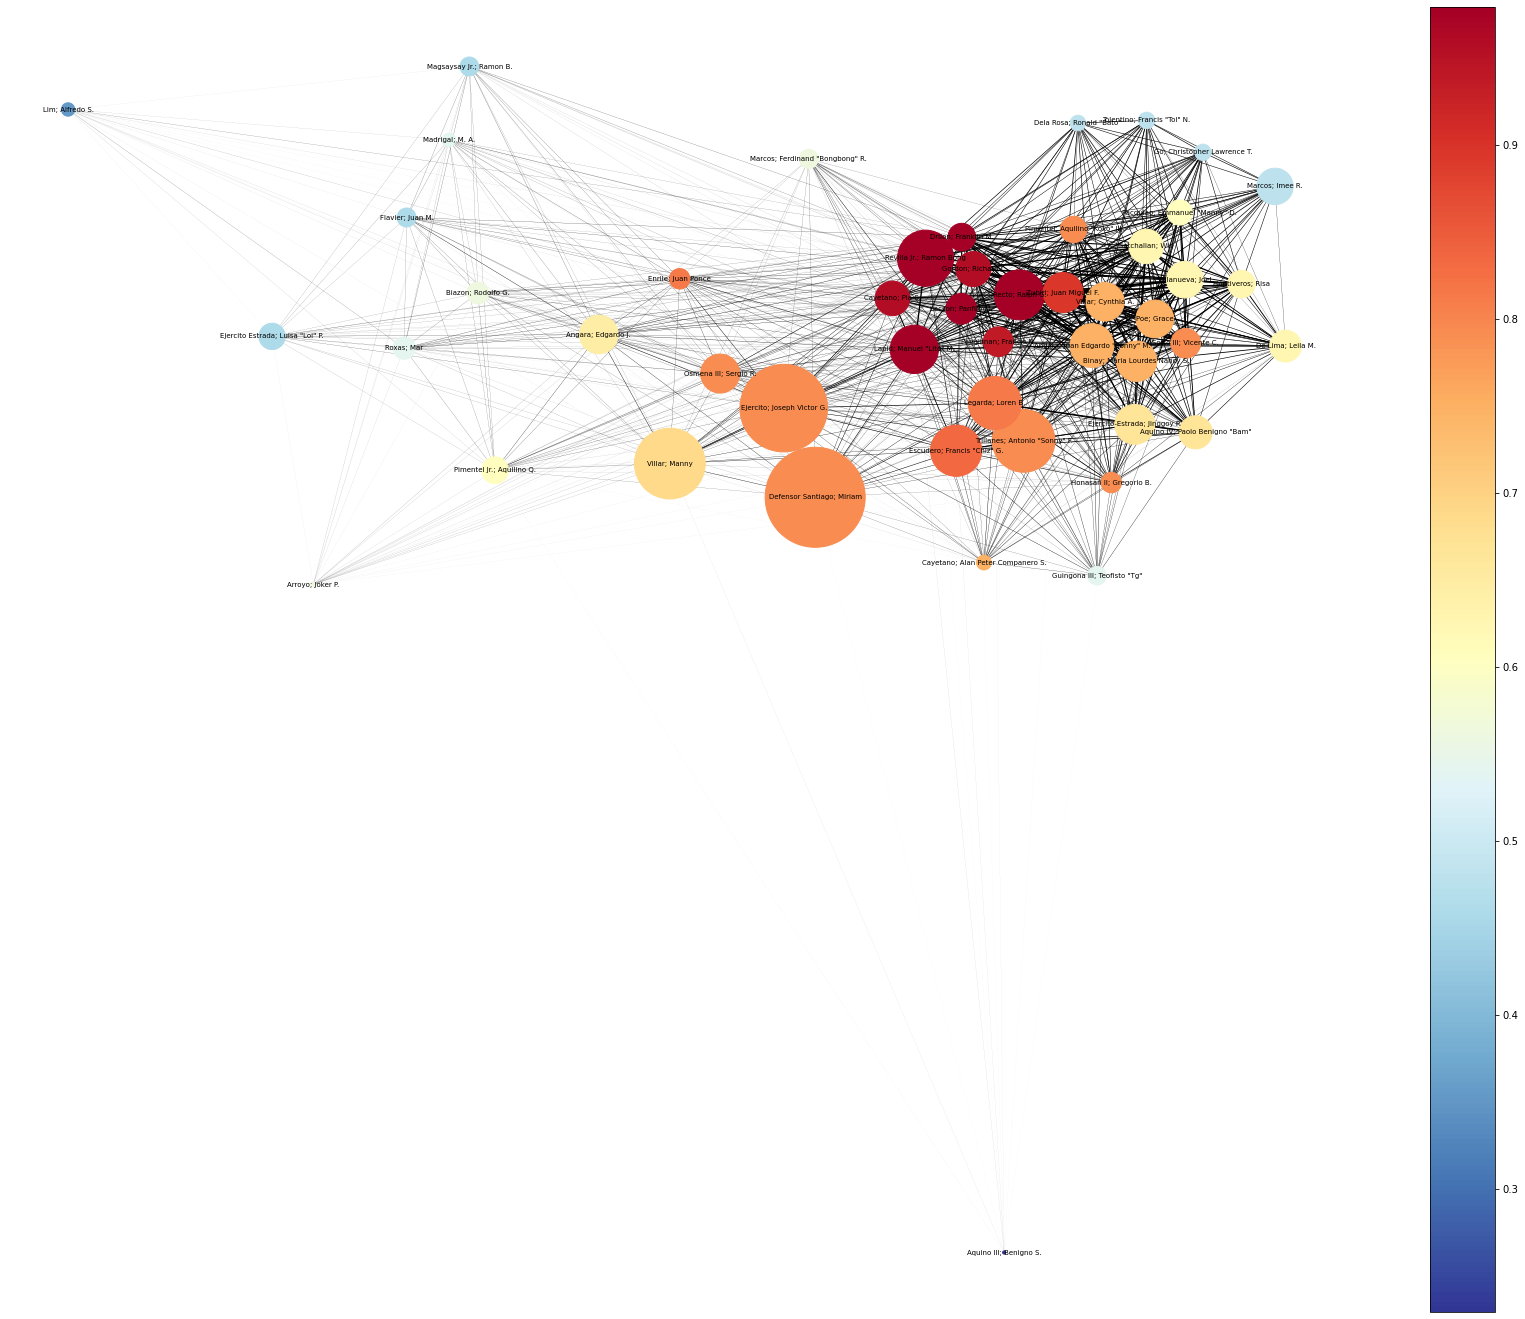

In [15]:
sen_wei = df5.groupby(['filed_by', 'filed_by2'])['weight'].mean().to_dict()

G = nx.from_pandas_edgelist(df5, 'filed_by', 'filed_by2', edge_attr='weight')
pos = nx.fruchterman_reingold_layout(G, seed=1)

plt.figure(figsize=(30,24));
plt.axis("off");
nc = nx.draw_networkx_nodes(G, pos, node_size=[i[1]*10000 for i in sizes_scaled], cmap=plt.cm.RdYlBu_r,
                            node_color=[nx.degree_centrality(G)[i[0]] for i in sizes_scaled],
                            nodelist=[i[0] for i in sizes_scaled]);
# nx.draw_networkx_edges(G, pos, alpha=0.3);
nx.draw_networkx_edges(G, pos, width=[sen_wei[i]*2 for i in G.edges]);
# nx.draw_networkx_edges(G, pos, width=[sen_wei[i]*2 for i in G.edges], edge_color=[sen_wei[i] for i in G.edges], edge_cmap=plt.cm.Greys);
# nx.draw_networkx_edges(G, pos, edge_color=[sen_wei[i] for i in G.edges], edge_cmap=plt.cm.Greys);
nx.draw_networkx_labels(G, pos, font_color ='k', font_size=7);
plt.colorbar(nc);

In [16]:
print(NetworkProperties(G))

Network Properties:
N = 49
L = 815
avg_degree = 16.632653061224488
max_degree = 47
min_degree = 11
density = 0.34651360544217685
avg_shortest_path = 1.3069727891156462
avg_clustering_coeff = 0.8631477863771769
shortest_path_length_max = 2.0
shortest_path_length_max_edge = ('Angara; Edgardo J.', 'Angara; Juan Edgardo "Sonny" M.')
is_connected = True
maximal_cliques = 26


In [17]:
# cmap = plt.cm.turbo

# plt.figure(figsize=(30,30))
# nx.draw(G, pos=pos, node_size=[i[1]*5000 for i in sizes_scaled],
#         nodelist=[i[0] for i in sizes_scaled]);
# nx.draw_networkx_labels(G, pos, font_color ='k');
# nx.draw_networkx_edges(G, pos, edgelist=df5[['filed_by', 'filed_by2']].to_numpy().tolist(),
#                        edge_cmap=cmap, edge_color=df5.weight.to_numpy().tolist(),
#                        width=(df5.weight**2).to_numpy()*10);

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
# sm._A = []
# plt.colorbar(sm);

In [18]:
sorted(nx.degree_centrality(G).items(), key=lambda x: -x[1])[:7]

[('Drilon; Franklin M.', 0.9791666666666666),
 ('Lacson; Panfilo M.', 0.9791666666666666),
 ('Lapid; Manuel "Lito" M.', 0.9791666666666666),
 ('Recto; Ralph G.', 0.9791666666666666),
 ('Revilla Jr.; Ramon Bong', 0.9791666666666666),
 ('Cayetano; Pia S.', 0.9583333333333333),
 ('Gordon; Richard J.', 0.9583333333333333)]

The senators with high collaboratoin are as above. They are not the exact same as those with a high total number of bills. This leads us to the 4 quadrants of low-high collaboration and low-high total number of bills.


In [19]:
len(senators)

49

In [49]:
import plotly
quad = pd.merge(pd.DataFrame(sorted(sizes), columns=['sen', 'bills']),
         pd.DataFrame(nx.degree_centrality(G).items(), columns=['sen', 'collaboration']), on='sen')
fig = px.scatter(quad, 'bills', 'collaboration', hover_name='sen', size='bills',
                 color='collaboration', color_continuous_scale=['blue', 'yellow', 'red'], range_color=[0,1]);
fig.show();

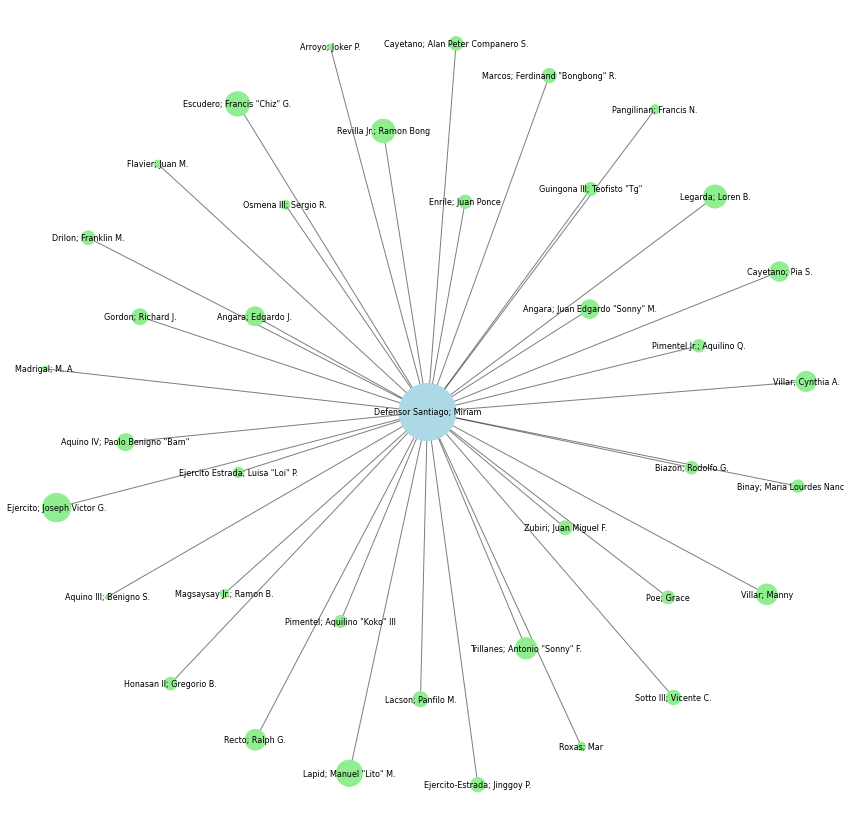

In [151]:
miriam = df5[df5.filed_by=='Defensor Santiago; Miriam']

G1 = nx.from_pandas_edgelist(miriam, 'filed_by', 'filed_by2', edge_attr='uniquebill')
pos1 = nx.spring_layout(G1)

color_map = []
s3 = []
for x in list(G1.nodes):
    if x != 'Defensor Santiago; Miriam':
        color_map.append('lightgreen')
        s3.append(list(miriam[miriam.filed_by2==x].uniquebill)[0]*3)
    else:
        color_map.append('lightblue')
        s3.append(miriam.uniquebill.sum())

plt.figure(figsize=(15,15));
plt.axis("off");
nx.draw_networkx_nodes(G1, pos1, node_color=color_map, node_size=s3);
nx.draw_networkx_edges(G1, pos1, alpha=0.500);
nx.draw_networkx_labels(G1, pos1, font_color ='k', font_size=8);

The various senators who co-authored with Senator Santiago are as above.

#### Primary Commitee Bipartite

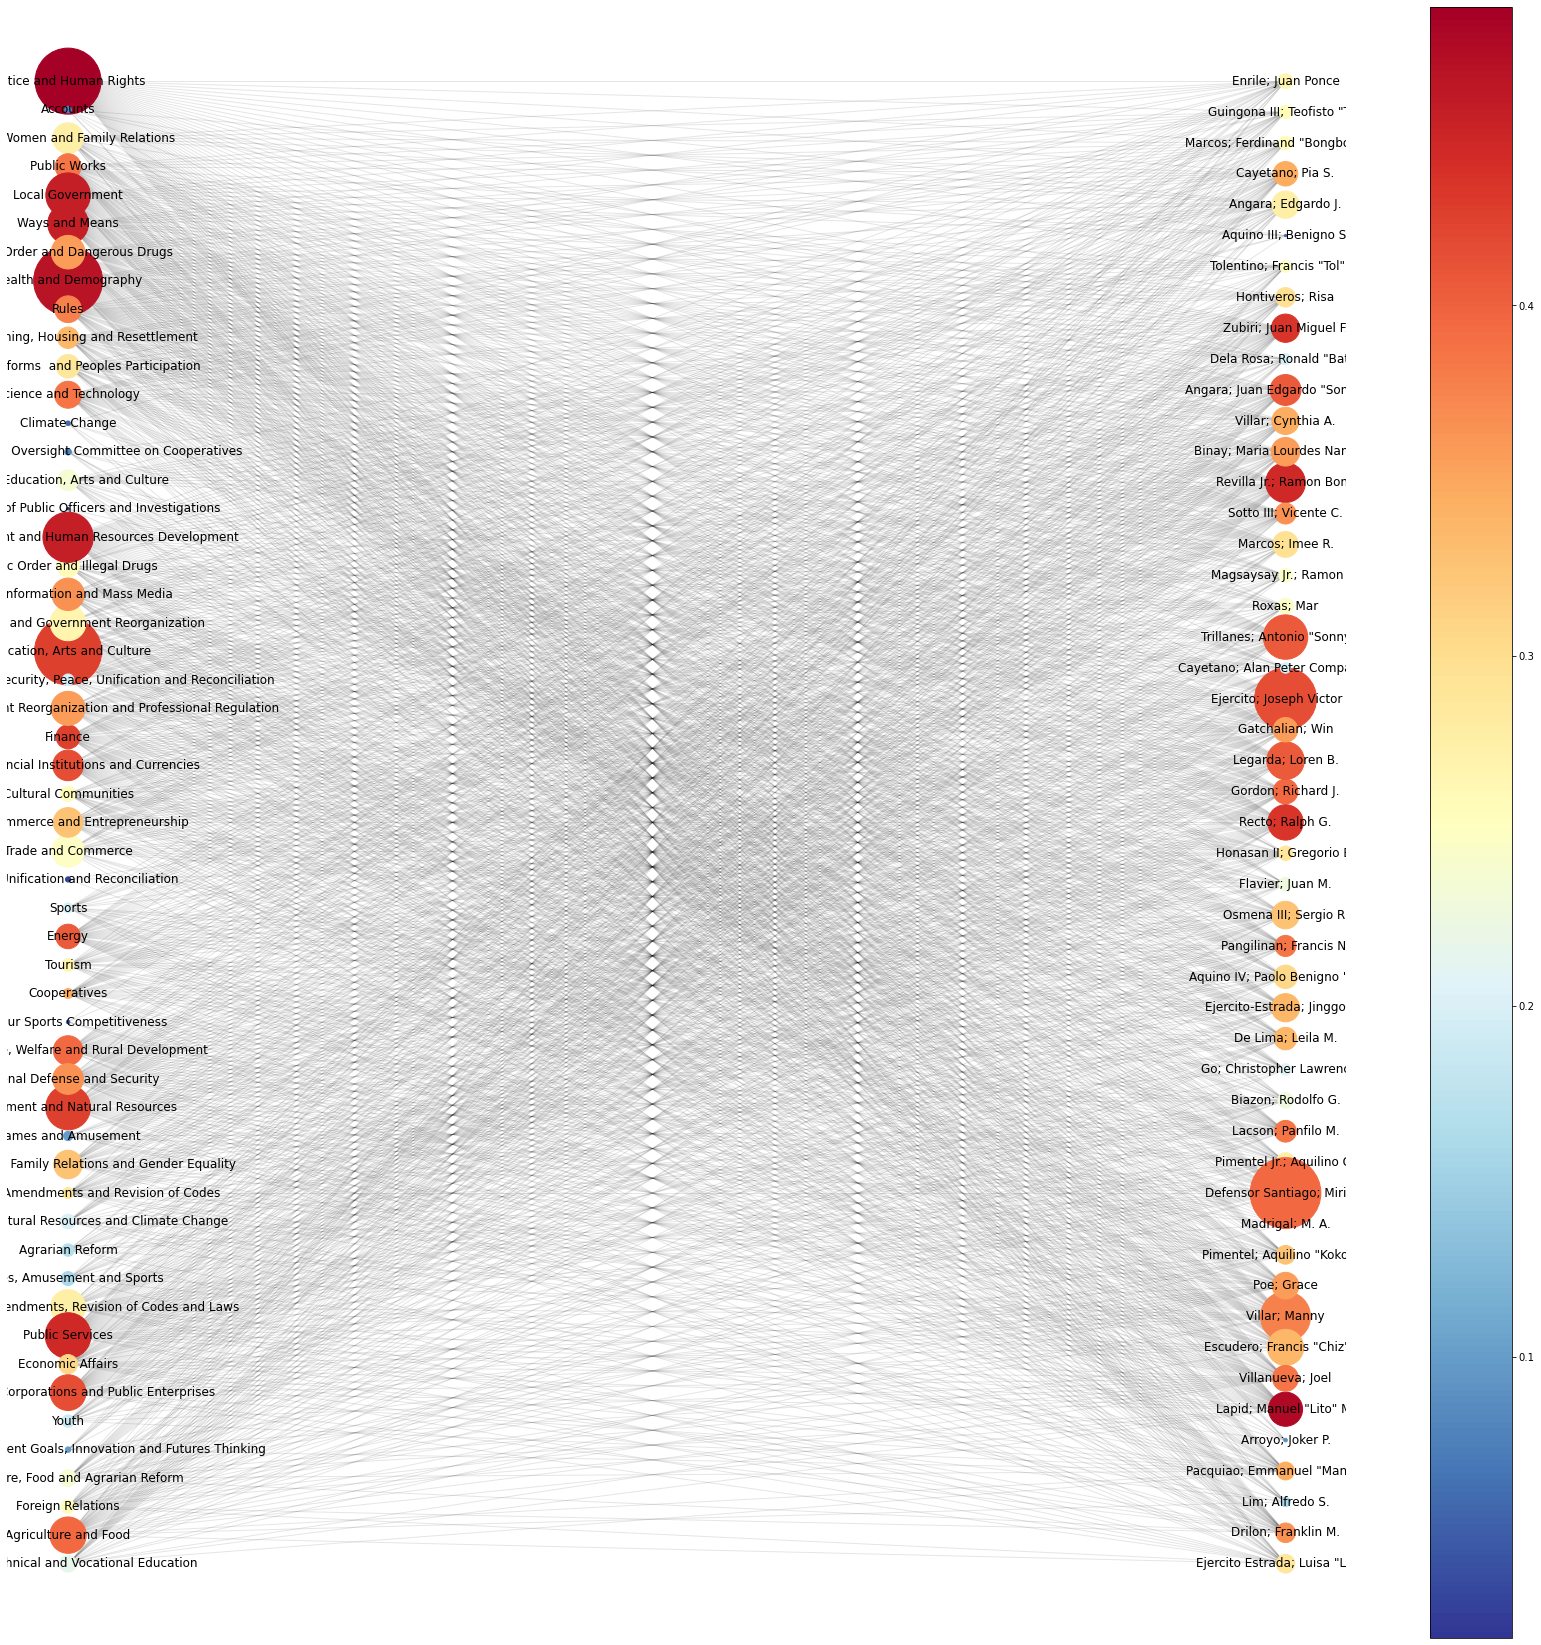

In [152]:
G2 = nx.Graph()
G2.add_nodes_from(senators, bipartite=0)

unique_commmittee = [i for i in df.primary_committee.unique() if type(i) != float]
G2.add_nodes_from(unique_commmittee, bipartite=1)
s2 = []
for i in G2.nodes():
    if i in df.primary_committee.unique():
        s2.append(df.primary_committee.value_counts().to_dict()[i]*3)
    else:
        s2.append(dict(sizes_scaled)[i]*5000)

edge_list = []
for i in df2.groupby('primary_committee')['filed_by'].apply(set).reset_index().to_numpy():
    for j in i[1]:
        edge_list.append((i[0], j))       
G2.add_edges_from(edge_list)        

pos1 = nx.bipartite_layout(G2, unique_commmittee) 

plt.figure(figsize=(30,30))
plt.axis("off");

nx.draw_networkx_labels(G2, pos=pos1, font_color ='k');
nx.draw_networkx_edges(G2, pos1, alpha=0.1);
# nx.draw(G2, pos = pos1, node_size=s2, node_color=color_map);
nc = nx.draw_networkx_nodes(G2, pos1, node_size=s2, cmap=plt.cm.RdYlBu_r,
                            node_color=list(nx.degree_centrality(G2).values()));
plt.colorbar(nc);

The right side of the graph with the senators shows the total number of bills through the node size while the color shows how active a senator is in multiple committees.

In [232]:
df6 = df2.groupby(['filed_by', 'primary_committee'])['uniquebill'].count().reset_index()
df6

filed_by  \
0         Angara; Edgardo J.   
1         Angara; Edgardo J.   
2         Angara; Edgardo J.   
3         Angara; Edgardo J.   
4         Angara; Edgardo J.   
...                      ...   
1541  Zubiri; Juan Miguel F.   
1542  Zubiri; Juan Miguel F.   
1543  Zubiri; Juan Miguel F.   
1544  Zubiri; Juan Miguel F.   
1545  Zubiri; Juan Miguel F.   

                                      primary_committee  uniquebill  
0                                              Accounts           2  
1                                  Agriculture and Food          14  
2          Banks, Financial Institutions and Currencies          32  
3           Civil Service and Government Reorganization          22  
4     Constitutional Amendments, Revision of Codes a...          18  
...                                                 ...         ...  
1541           Urban Planning, Housing and Resettlement           7  
1542                                     Ways and Means          23  
1543  Women, Children, Family Relations and Gender E...           5  
1544                                              Youth           1  
1545                  Youth, Women and Family Relations           2  

[1546 rows x 3 columns]

In [233]:
senators

array(['Flavier; Juan M.', 'Angara; Edgardo J.',
       'Ejercito Estrada; Luisa "Loi" P.', 'Osmena III; Sergio R.',
       'Villar; Manny', 'Gordon; Richard J.', 'Lacson; Panfilo M.',
       'Enrile; Juan Ponce', 'Ejercito; Joseph Victor G.',
       'Madrigal; M. A.', 'Drilon; Franklin M.',
       'Pimentel Jr.; Aquilino Q.', 'Magsaysay Jr.; Ramon B.',
       'Revilla Jr.; Ramon Bong', 'Defensor Santiago; Miriam',
       'Recto; Ralph G.', 'Biazon; Rodolfo G.', 'Lim; Alfredo S.',
       'Pangilinan; Francis N.', 'Lapid; Manuel "Lito" M.', 'Roxas; Mar',
       'Arroyo; Joker P.', 'Cayetano; Pia S.', 'Legarda; Loren B.',
       'Honasan II; Gregorio B.', 'Trillanes; Antonio "Sonny" F.',
       'Zubiri; Juan Miguel F.', 'Escudero; Francis "Chiz" G.',
       'Aquino III; Benigno S.', 'Cayetano; Alan Peter Companero S.',
       'Marcos; Ferdinand "Bongbong" R.', 'Sotto III; Vicente C.',
       'Guingona III; Teofisto "Tg"', 'Pimentel; Aquilino "Koko" III',
       'Villar; Cynthia A.', 'Eje

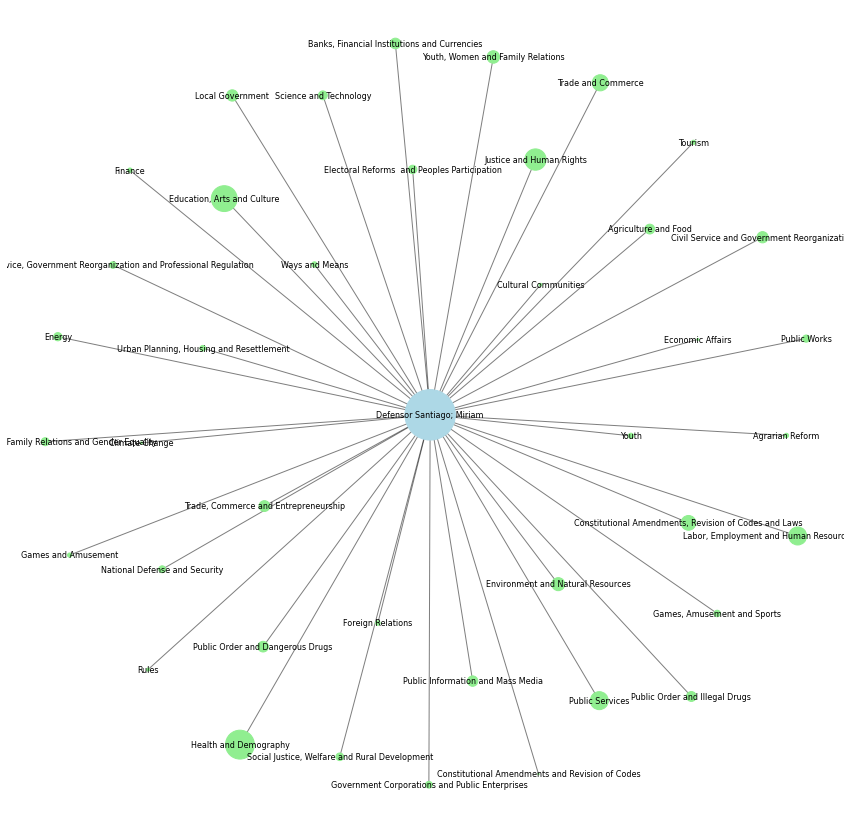

In [242]:
miriam = df6[df6.filed_by=='Defensor Santiago; Miriam']
# miriam = df6[df6.filed_by==senators[-9]]

G3 = nx.from_pandas_edgelist(miriam, 'filed_by', 'primary_committee', edge_attr='uniquebill')
pos2 = nx.spring_layout(G3)

color_map = []
s3 = []
for x in list(G3.nodes):
    if x in unique_commmittee:
        color_map.append('lightgreen')
        s3.append(list(miriam[miriam.primary_committee==x].uniquebill)[0]*2)
    else:
        color_map.append('lightblue')
        s3.append(miriam.uniquebill.sum())

plt.figure(figsize=(15,15));
plt.axis("off");
nx.draw_networkx_nodes(G3, pos2, node_color=color_map, node_size=s3);
nx.draw_networkx_edges(G3, pos2, alpha=0.500);
nx.draw_networkx_labels(G3, pos2, font_color ='k', font_size=8);

#### Primary Committee to Senator Projection

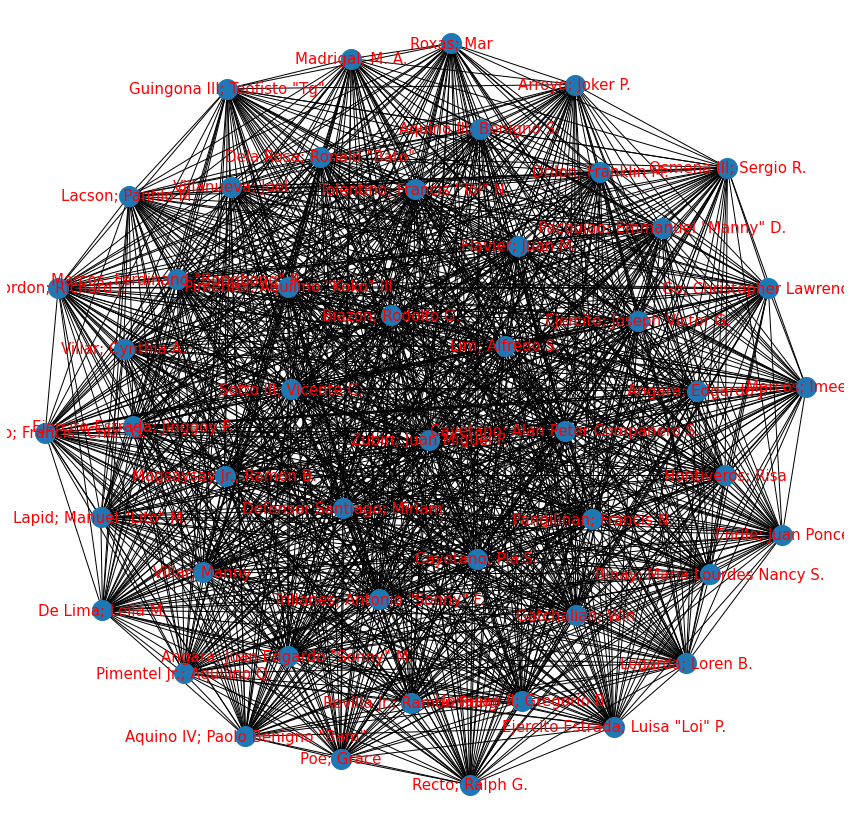

In [155]:
sen_nodes = set(n for n,d in G2.nodes(data=True) if d['bipartite']==0)
committee_nodes = set(G2) - sen_nodes
P = bipartite.projected_graph(G2, sen_nodes)

pos3 = nx.fruchterman_reingold_layout(P, seed=1)

plt.figure(figsize=(15,15))
nx.draw_networkx_labels(P, pos3, font_color ='red', font_size=15);
nx.draw(P, pos = pos3, node_size=400);

In [156]:
print(NetworkProperties(P))

Network Properties:
N = 49
L = 1176
avg_degree = 24.0
max_degree = 48
min_degree = 48
density = 0.5
avg_shortest_path = 1.0
avg_clustering_coeff = 1.0
shortest_path_length_max = 1.0
shortest_path_length_max_edge = ('Ejercito Estrada; Luisa "Loi" P.', 'Drilon; Franklin M.')
is_connected = True
maximal_cliques = 49


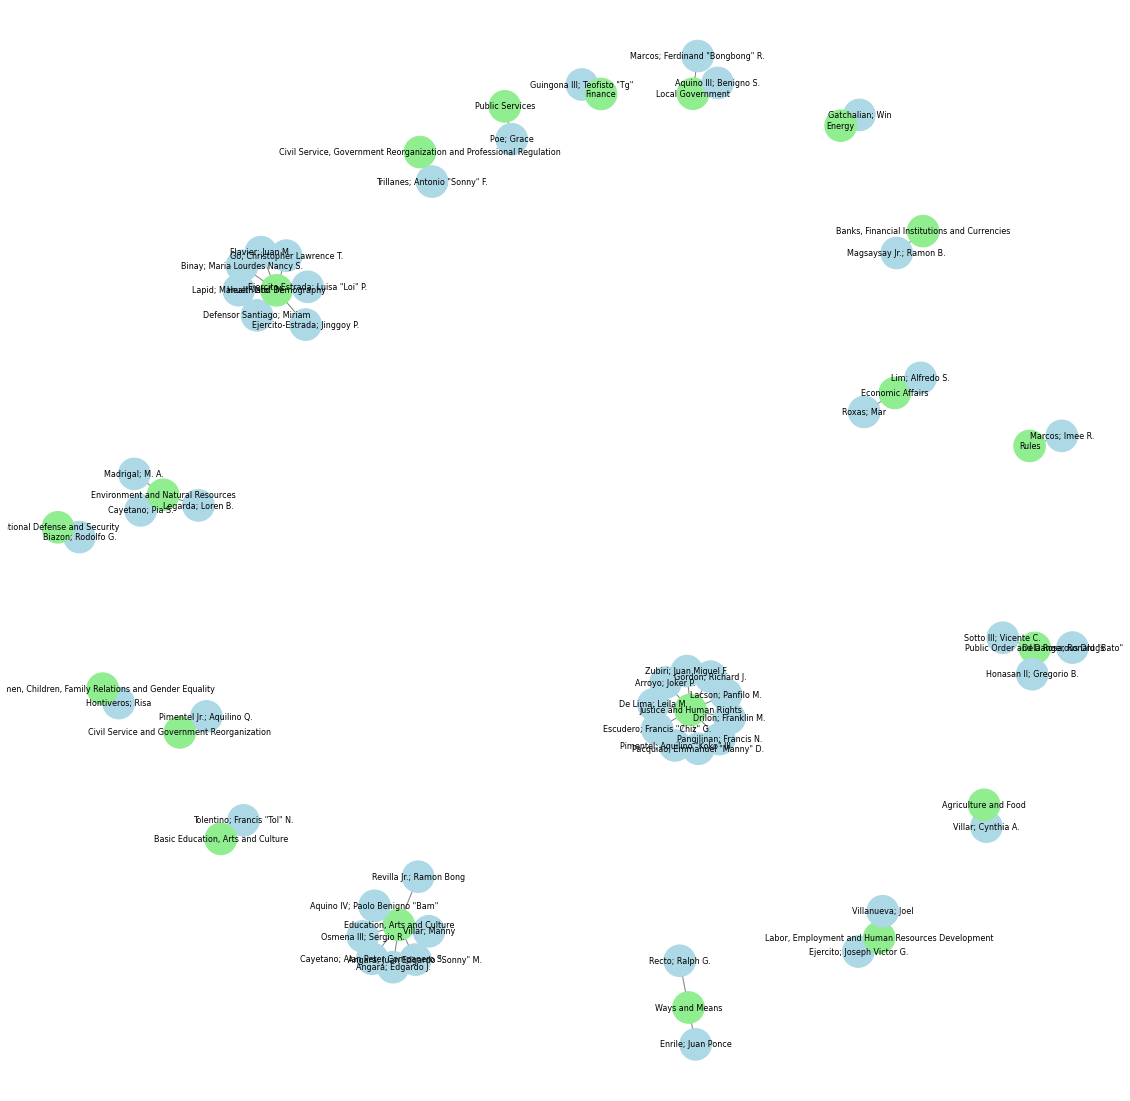

In [235]:
df7 = (df6.sort_values(by='uniquebill', ascending=False).drop_duplicates(subset='filed_by').reset_index(drop=True))

G4 = nx.from_pandas_edgelist(df7, 'filed_by', 'primary_committee', edge_attr='uniquebill')
pos4 = nx.spring_layout(G4)

color_map = []
s3 = []
for x in list(G4.nodes):
    if x in unique_commmittee:
        color_map.append('lightgreen')
#         s3.append(df.primary_committee.value_counts().to_dict()[x]*3)
    else:
        color_map.append('lightblue')
#         s3.append(list(df6[df6.filed_by==x]['uniquebill'])[0])

plt.figure(figsize=(20,20));
plt.axis("off");
nx.draw_networkx_nodes(G4, pos4, node_color=color_map, node_size=1000);
nx.draw_networkx_edges(G4, pos4, alpha=0.500);
nx.draw_networkx_labels(G4, pos4, font_color ='k', font_size=8);

The graph shows the senators grouped with their dominant committee.

#### Bipartite Congress Group

In [194]:
df2.groupby('congress')['filed_by'].nunique()

congress
13    23
14    23
15    24
16    24
17    24
18    24
Name: filed_by, dtype: int64

In [336]:
df2.groupby('filed_by')['congress'].apply(set)

filed_by
Angara; Edgardo J.                           {13, 14, 15}
Angara; Juan Edgardo "Sonny" M.              {16, 17, 18}
Aquino III; Benigno S.                               {14}
Aquino IV; Paolo Benigno "Bam"                   {16, 17}
Arroyo; Joker P.                             {13, 14, 15}
Biazon; Rodolfo G.                               {13, 14}
Binay; Maria Lourdes Nancy S.                {16, 17, 18}
Cayetano; Alan Peter Companero S.        {16, 17, 14, 15}
Cayetano; Pia S.                     {13, 14, 15, 16, 18}
De Lima; Leila M.                                {17, 18}
Defensor Santiago; Miriam                {16, 13, 14, 15}
Dela Rosa; Ronald "Bato"                             {18}
Drilon; Franklin M.                  {13, 15, 16, 17, 18}
Ejercito Estrada; Luisa "Loi" P.                     {13}
Ejercito-Estrada; Jinggoy P.                     {16, 17}
Ejercito; Joseph Victor G.               {16, 13, 14, 15}
Enrile; Juan Ponce                       {16, 13, 14, 15}
Escud

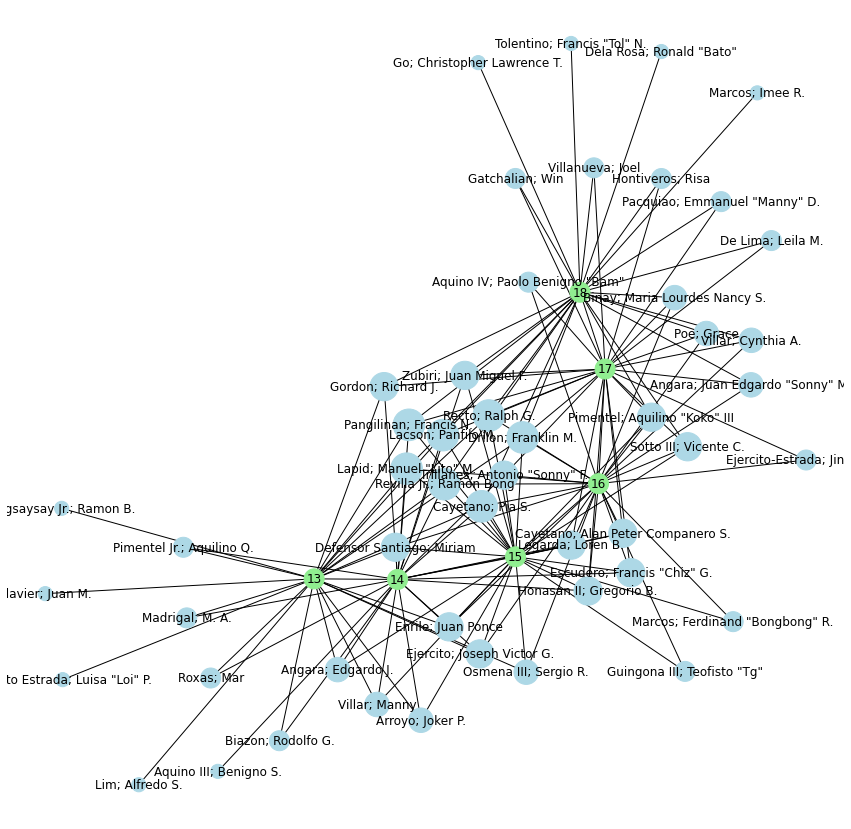

In [53]:
G5 = nx.Graph()
G5.add_nodes_from(senators, bipartite=0)
G5.add_nodes_from(df.congress.unique(), bipartite=1)
G5.add_edges_from(list(zip(df.congress.unique(), df.congress.unique()[1:])))

unique_congress = [i for i in df.congress.unique() if type(i) != float]

for i in df2.groupby('congress')['filed_by'].apply(set).reset_index().to_numpy():
    for j in i[1]:
        G5.add_edge(i[0], j)

pos5 = nx.fruchterman_reingold_layout(G5, seed=1)

color_map = []
s = []
for x in list(G5.nodes):
    if x not in unique_congress:
        color_map.append('lightblue')
        s.append(df2.groupby('filed_by')['congress'].nunique().to_dict()[x]*200)
    else:
        color_map.append('lightgreen') 
        s.append(400)     
           
plt.figure(figsize=(15,15))
nx.draw_networkx_labels(G5, pos5, font_color ='k');
nx.draw(G5, pos=pos5, node_color=color_map, node_size=s);

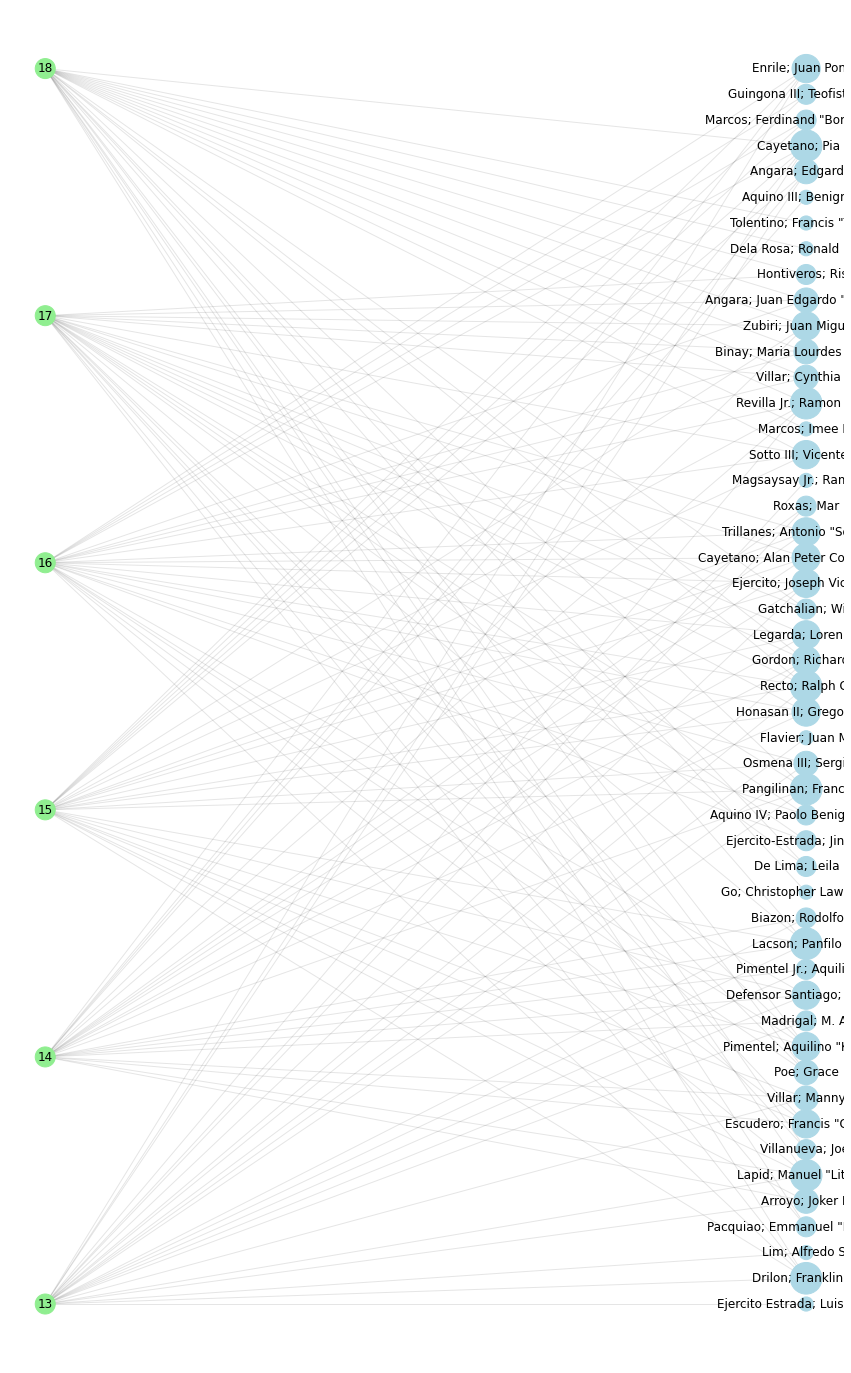

In [159]:
G6 = nx.Graph()
G6.add_nodes_from(senators, bipartite=0)
G6.add_nodes_from(unique_congress, bipartite=1)

edge_list = []
for i in df2.groupby('congress')['filed_by'].apply(set).reset_index().to_numpy():
    for j in i[1]:
        edge_list.append((i[0], j))
        
G6.add_edges_from(edge_list)        

pos6 = nx.bipartite_layout(G6, unique_congress)

color_map = []
s = []
for x in list(G6.nodes):
    if x not in unique_congress:
        color_map.append('lightblue')
        s.append(df2.groupby('filed_by')['congress'].nunique().to_dict()[x]*200)
    else:
        color_map.append('lightgreen') 
        s.append(400)        

plt.figure(figsize=(15,25))
plt.axis("off");

nx.draw_networkx_nodes(G6, pos=pos6, node_color=color_map, node_size=s)
nx.draw_networkx_labels(G6, pos6, font_color ='k');
nx.draw_networkx_edges(G6, pos6, alpha=0.1);

The different sizes of senators show their activity in different congresses. There are many senators who got elected at most 5 times.

#### Community

In [60]:
giant = nx.subgraph(G, max(nx.connected_components(G), key=len)).copy()
lm = LouvainMethod()
lm.fit(giant)
partition = community.best_partition(giant)
print('Total Communinties Detected on Louvian Method: ', 
      len(set(partition.values())))

Total Communinties Detected on Louvian Method:  3


In [183]:
lm_df = df2.groupby('filed_by')['congress'].apply(set).reset_index()
lm_df['group'] = lm_df.filed_by.replace(partition)
lm_df.sort_values(by='group')

filed_by              congress  group
0                  Angara; Edgardo J.          {13, 14, 15}      0
30            Magsaysay Jr.; Ramon B.                  {13}      0
29                    Madrigal; M. A.              {13, 14}      0
28                    Lim; Alfredo S.                  {13}      0
26            Lapid; Manuel "Lito" M.  {13, 14, 15, 16, 18}      0
47                      Villar; Manny          {13, 14, 15}      0
40            Revilla Jr.; Ramon Bong  {13, 14, 15, 16, 18}      0
41                         Roxas; Mar              {13, 14}      0
18                   Flavier; Juan M.                  {13}      0
33              Osmena III; Sergio R.          {16, 13, 15}      0
16                 Enrile; Juan Ponce      {16, 13, 14, 15}      0
15         Ejercito; Joseph Victor G.      {16, 13, 14, 15}      0
13   Ejercito Estrada; Luisa "Loi" P.                  {13}      0
36          Pimentel Jr.; Aquilino Q.              {13, 14}      0
5                  Biazon; Rodolfo G.              {13, 14}      0
10          Defensor Santiago; Miriam      {16, 13, 14, 15}      0
2              Aquino III; Benigno S.                  {14}      0
8                    Cayetano; Pia S.  {13, 14, 15, 16, 18}      0
4                    Arroyo; Joker P.          {13, 14, 15}      0
31    Marcos; Ferdinand "Bongbong" R.              {16, 15}      1
3      Aquino IV; Paolo Benigno "Bam"              {16, 17}      1
27                  Legarda; Loren B.      {16, 17, 14, 15}      1
23            Honasan II; Gregorio B.      {16, 17, 14, 15}      1
14       Ejercito-Estrada; Jinggoy P.              {16, 17}      1
7   Cayetano; Alan Peter Companero S.      {16, 17, 14, 15}      1
44      Trillanes; Antonio "Sonny" F.      {16, 17, 14, 15}      1
22        Guingona III; Teofisto "Tg"              {16, 15}      1
17        Escudero; Francis "Chiz" G.      {16, 17, 14, 15}      1
42              Sotto III; Vicente C.      {16, 17, 18, 15}      2
38                         Poe; Grace          {16, 17, 18}      2
39                    Recto; Ralph G.  {13, 15, 16, 17, 18}      2
45                   Villanueva; Joel              {17, 18}      2
46                 Villar; Cynthia A.          {16, 17, 18}      2
43        Tolentino; Francis "Tol" N.                  {18}      2
37      Pimentel; Aquilino "Koko" III      {16, 17, 18, 15}      2
24                   Hontiveros; Risa              {17, 18}      2
34      Pacquiao; Emmanuel "Manny" D.              {17, 18}      2
32                    Marcos; Imee R.                  {18}      2
25                 Lacson; Panfilo M.  {13, 14, 15, 17, 18}      2
21                 Gordon; Richard J.      {17, 18, 13, 14}      2
20        Go; Christopher Lawrence T.                  {18}      2
19                    Gatchalian; Win              {17, 18}      2
12                Drilon; Franklin M.  {13, 15, 16, 17, 18}      2
11           Dela Rosa; Ronald "Bato"                  {18}      2
9                   De Lima; Leila M.              {17, 18}      2
6       Binay; Maria Lourdes Nancy S.          {16, 17, 18}      2
1     Angara; Juan Edgardo "Sonny" M.          {16, 17, 18}      2
35             Pangilinan; Francis N.  {13, 14, 15, 17, 18}      2
48             Zubiri; Juan Miguel F.      {17, 18, 14, 15}      2

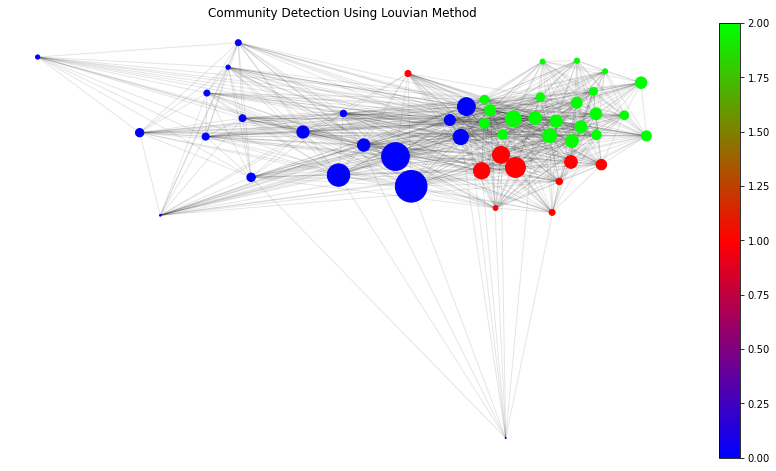

In [71]:
plt.figure(figsize=(15, 8))
plt.axis('off')

nc = nx.draw_networkx_nodes(giant, pos, cmap='brg', 
                       node_color=[partition[i[0]] for i in sizes_scaled],
                       node_size=[i[1]*1000 for i in sizes_scaled],
                       nodelist=[i[0] for i in sizes_scaled])
nx.draw_networkx_edges(giant, pos, alpha=0.1)

plt.title('Community Detection Using Louvian Method')
plt.colorbar(nc)
plt.show()

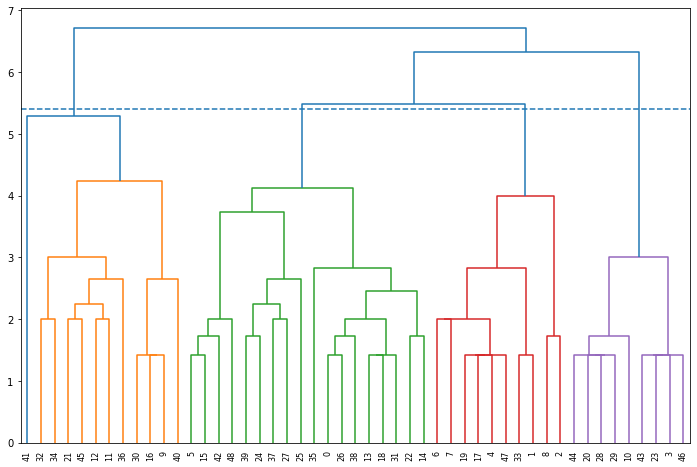

In [66]:
hc = HierarchicalClustering(t=5.4, method='complete')
hc.fit(giant)

fig, ax = plt.subplots(figsize=(12, 8))
ax = hc.plot_dendogram(ax)
ax.axhline(5.4, linestyle='--')
plt.show()

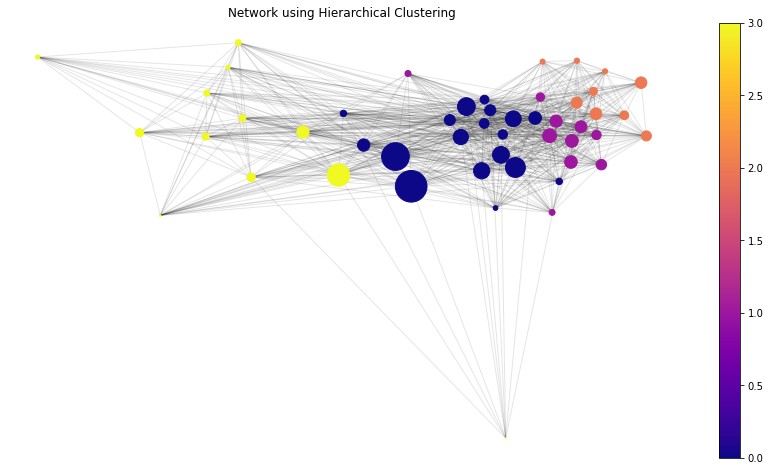

In [69]:
hc_result = hc.transform()

plt.figure(figsize=(15, 8))
# pos = nx.spring_layout(giant, seed=11)
node_size = NodeSizeScaler(min_size=30, max_size=350).fit_transform(giant)

nc=nx.draw_networkx_nodes(giant, pos, cmap='plasma',
                          node_color=[dict(zip(giant.nodes, hc_result))[i[0]] for i in sizes_scaled],
                          node_size=[i[1]*1000 for i in sizes_scaled],
                          nodelist=[i[0] for i in sizes_scaled])
nx.draw_networkx_edges(giant, pos, alpha=0.1)

plt.title('Network using Hierarchical Clustering')
plt.axis('off')

# legend_elements = [Line2D([0], [0], color='deeppink', lw=4, label='Highly Popular'),
#                   Line2D([0], [0], color='darkblue', lw=4, label='Average'),
#                   Line2D([0], [0], color='yellow', lw=4, label='Loner')]
# plt.legend(handles=legend_elements, loc='upper right')
plt.colorbar(nc);
plt.show()

In [188]:
hc_df = df2.groupby('filed_by')['congress'].apply(set).reset_index()
hc_df['group'] = hc_df.filed_by.replace(dict(zip(giant.nodes, hc_result)))
hc_df.sort_values(by='group')

filed_by              congress  group
48             Zubiri; Juan Miguel F.      {17, 18, 14, 15}      0
33              Osmena III; Sergio R.          {16, 13, 15}      0
27                  Legarda; Loren B.      {16, 17, 14, 15}      0
26            Lapid; Manuel "Lito" M.  {13, 14, 15, 16, 18}      0
25                 Lacson; Panfilo M.  {13, 14, 15, 17, 18}      0
35             Pangilinan; Francis N.  {13, 14, 15, 17, 18}      0
23            Honasan II; Gregorio B.      {16, 17, 14, 15}      0
21                 Gordon; Richard J.      {17, 18, 13, 14}      0
39                    Recto; Ralph G.  {13, 15, 16, 17, 18}      0
17        Escudero; Francis "Chiz" G.      {16, 17, 14, 15}      0
16                 Enrile; Juan Ponce      {16, 13, 14, 15}      0
40            Revilla Jr.; Ramon Bong  {13, 14, 15, 16, 18}      0
15         Ejercito; Joseph Victor G.      {16, 13, 14, 15}      0
10          Defensor Santiago; Miriam      {16, 13, 14, 15}      0
8                    Cayetano; Pia S.  {13, 14, 15, 16, 18}      0
44      Trillanes; Antonio "Sonny" F.      {16, 17, 14, 15}      0
7   Cayetano; Alan Peter Companero S.      {16, 17, 14, 15}      0
12                Drilon; Franklin M.  {13, 15, 16, 17, 18}      0
42              Sotto III; Vicente C.      {16, 17, 18, 15}      1
1     Angara; Juan Edgardo "Sonny" M.          {16, 17, 18}      1
46                 Villar; Cynthia A.          {16, 17, 18}      1
3      Aquino IV; Paolo Benigno "Bam"              {16, 17}      1
6       Binay; Maria Lourdes Nancy S.          {16, 17, 18}      1
22        Guingona III; Teofisto "Tg"              {16, 15}      1
38                         Poe; Grace          {16, 17, 18}      1
14       Ejercito-Estrada; Jinggoy P.              {16, 17}      1
37      Pimentel; Aquilino "Koko" III      {16, 17, 18, 15}      1
31    Marcos; Ferdinand "Bongbong" R.              {16, 15}      1
45                   Villanueva; Joel              {17, 18}      2
43        Tolentino; Francis "Tol" N.                  {18}      2
32                    Marcos; Imee R.                  {18}      2
34      Pacquiao; Emmanuel "Manny" D.              {17, 18}      2
24                   Hontiveros; Risa              {17, 18}      2
20        Go; Christopher Lawrence T.                  {18}      2
19                    Gatchalian; Win              {17, 18}      2
11           Dela Rosa; Ronald "Bato"                  {18}      2
9                   De Lima; Leila M.              {17, 18}      2
29                    Madrigal; M. A.              {13, 14}      3
28                    Lim; Alfredo S.                  {13}      3
47                      Villar; Manny          {13, 14, 15}      3
36          Pimentel Jr.; Aquilino Q.              {13, 14}      3
18                   Flavier; Juan M.                  {13}      3
13   Ejercito Estrada; Luisa "Loi" P.                  {13}      3
41                         Roxas; Mar              {13, 14}      3
5                  Biazon; Rodolfo G.              {13, 14}      3
4                    Arroyo; Joker P.          {13, 14, 15}      3
2              Aquino III; Benigno S.                  {14}      3
30            Magsaysay Jr.; Ramon B.                  {13}      3
0                  Angara; Edgardo J.          {13, 14, 15}      3

#### Political Party

In [244]:
sen_party

{'Angara; Edgardo J.': 'LDP',
 'Angara; Juan Edgardo "Sonny" M.': 'LDP',
 'Aquino III; Benigno S.': 'LP',
 'Aquino IV; Paolo Benigno "Bam"': 'LP',
 'Arroyo; Joker P.': 'LCMD',
 'Biazon; Rodolfo G.': 'LP',
 'Binay; Maria Lourdes Nancy S.': 'UNA',
 'Cayetano; Alan Peter Companero S.': 'NP',
 'Cayetano; Pia S.': 'NP',
 'De Lima; Leila M.': 'LP',
 'Defensor Santiago; Miriam': 'PRP',
 'Dela Rosa; Ronald "Bato"': 'PDPL',
 'Drilon; Franklin M.': 'LP',
 'Ejercito Estrada; Luisa "Loi" P.': 'PMP',
 'Ejercito-Estrada; Jinggoy P.': 'NPC',
 'Ejercito; Joseph Victor G.': 'PMP',
 'Enrile; Juan Ponce': 'PMP',
 'Escudero; Francis "Chiz" G.': 'I',
 'Flavier; Juan M.': 'LCMD',
 'Gatchalian; Win': 'NPC',
 'Go; Christopher Lawrence T.': 'PDPL',
 'Gordon; Richard J.': 'I',
 'Guingona III; Teofisto "Tg"': 'LP',
 'Honasan II; Gregorio B.': 'UNA',
 'Hontiveros; Risa': 'ACAP',
 'Lacson; Panfilo M.': 'I',
 'Lapid; Manuel "Lito" M.': 'NPC',
 'Legarda; Loren B.': 'NPC',
 'Lim; Alfredo S.': 'PMP',
 'Madrigal; M. A.

In [74]:
parties = ['LDP', 'LDP', 'LP', 'LP', 'LCMD', 'LP', 'UNA', 'NP',
           'NP', 'LP', 'PRP', 'PDPL', 'LP', 'PMP', 'NPC', 'PMP',
           'PMP', 'I', 'LCMD', 'NPC', 'PDPL', 'I', 'LP', 'UNA', 
           'ACAP', 'I', 'NPC', 'NPC', 'PMP', 'I', 'LCMD', 'NP',
           'NP', 'I', 'PDPL', 'LP', 'PDPL', 'PDPL', 'I', 'NP',
           'LCMD', 'LP', 'NPC', 'PDPL', 'NP', 'CIBAC', 'NP', 'NP', 'I']

sen_party = {i:j for i, j in zip(sorted(senators), parties)}

The party used per member was the one in which the member was most recently active in as a senator.

In [75]:
df8 = df5.copy()
df8[['filed_by', 'filed_by2']] = df8[['filed_by', 'filed_by2']].replace(sen_party)
df8 = df8.groupby(['filed_by', 'filed_by2'])[['uniquebill', 'weight']].sum().reset_index()

In [77]:
par_wei = df8.groupby(['filed_by', 'filed_by2'])['weight'].mean().to_dict()

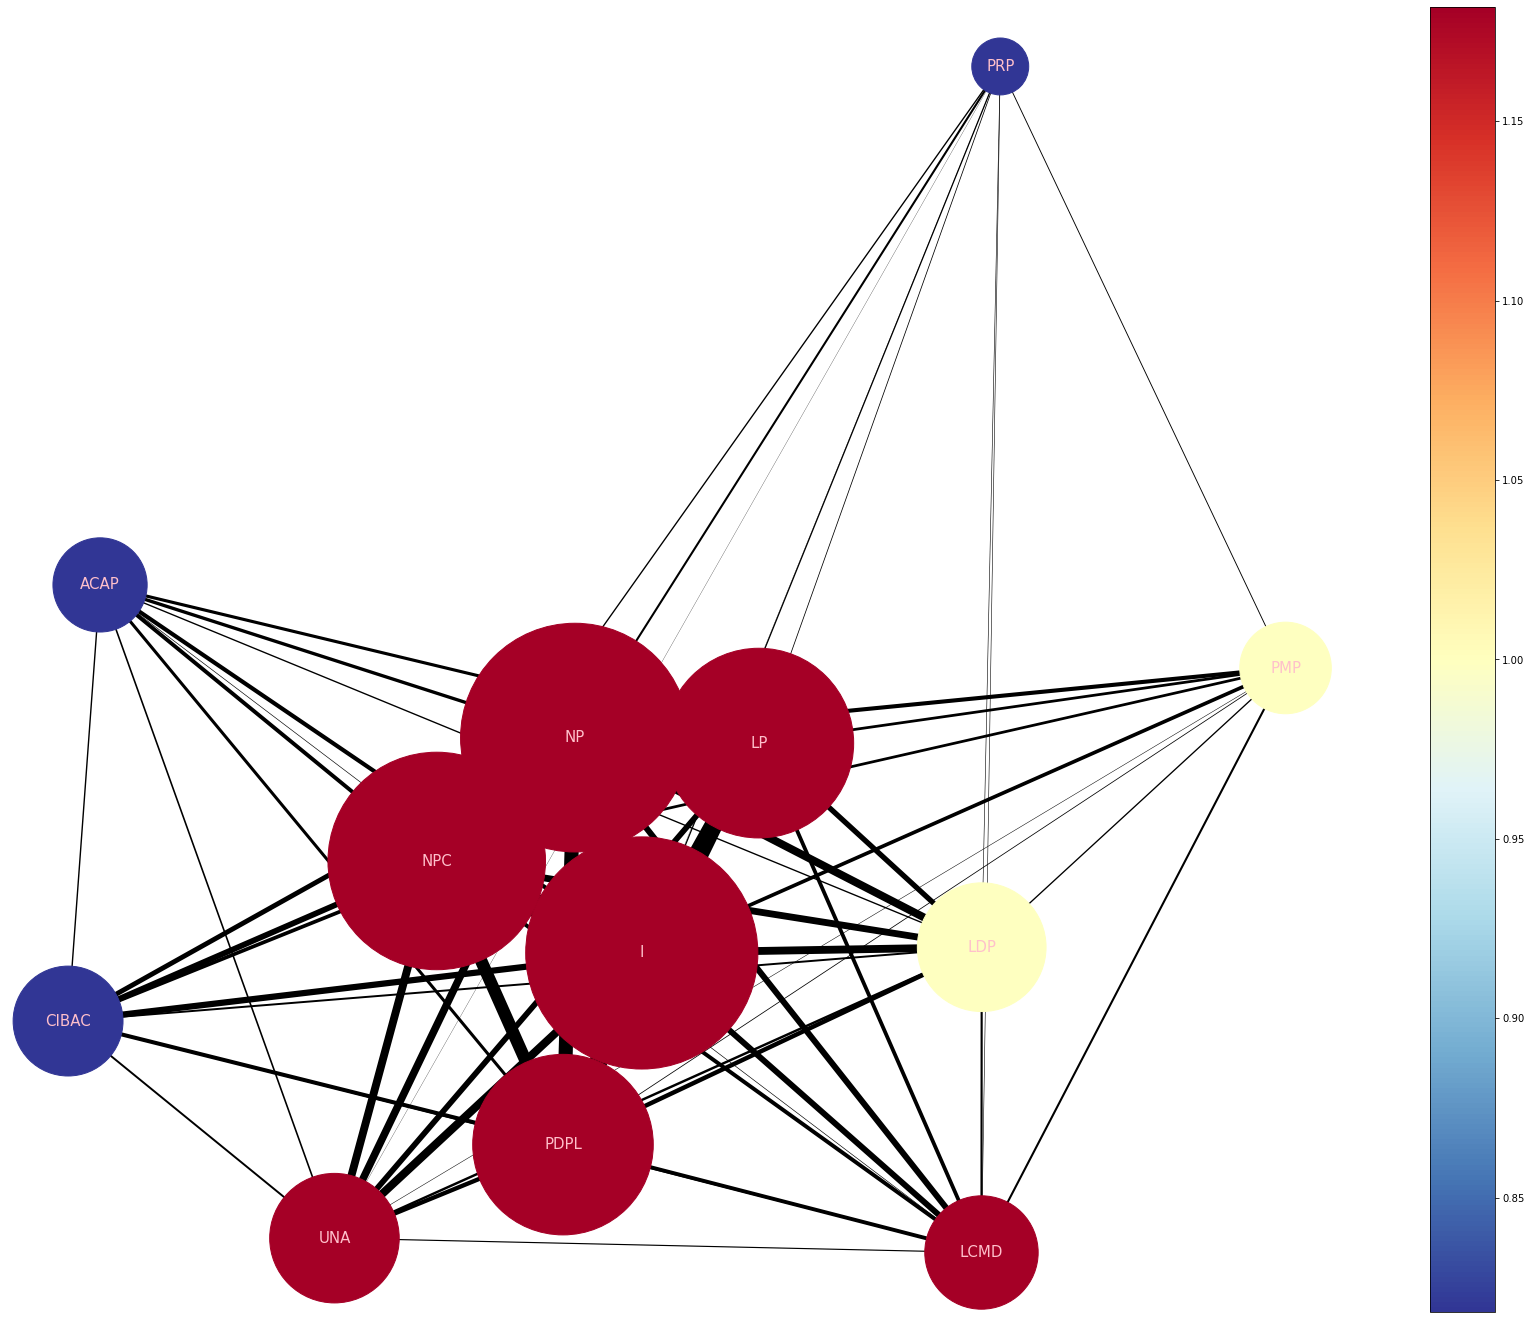

In [79]:
G7 = nx.from_pandas_edgelist(df8, 'filed_by', 'filed_by2', edge_attr='weight')
pos8 = nx.fruchterman_reingold_layout(G7, seed=1)

plt.figure(figsize=(30,24));
plt.axis("off");
nc = nx.draw_networkx_nodes(G7, pos8, node_size=[df8.groupby('filed_by')['uniquebill'].sum().to_dict()[i] for i in G7.nodes],
                            cmap=plt.cm.RdYlBu_r,
                            node_color=list(nx.degree_centrality(G7).values()));
# nx.draw_networkx_edges(G7, pos8, alpha=0.500);
nx.draw_networkx_edges(G7, pos8, width=[par_wei[i]*2 for i in G7.edges]);
nx.draw_networkx_labels(G7, pos8, font_color='pink', font_size=15);
plt.colorbar(nc);

In [81]:
print(NetworkProperties(G7))

Network Properties:
N = 12
L = 70
avg_degree = 5.833333333333333
max_degree = 13
min_degree = 9
density = 0.5303030303030303
avg_shortest_path = 1.0606060606060606
avg_clustering_coeff = 0.9515151515151516
shortest_path_length_max = 2.0
shortest_path_length_max_edge = ('ACAP', 'PMP')
is_connected = True
maximal_cliques = 10


In [127]:
list(zip(G8.nodes, s2))

[('PRP', 1620.0),
 ('LCMD', 6428.0),
 ('CIBAC', 6038.0),
 ('LDP', 8286.0),
 ('I', 26948.0),
 ('UNA', 8390.0),
 ('PMP', 4193.0),
 ('ACAP', 4437.0),
 ('LP', 17993.0),
 ('NP', 26155.0),
 ('PDPL', 16300.0),
 ('NPC', 23656.0),
 ('Health and Demography', 4743),
 ('Constitutional Amendments, Revision of Codes and Laws', 1209),
 ('Government Corporations and Public Enterprises', 1275),
 ('Ways and Means', 1653),
 ('Environment and Natural Resources', 1998),
 ('Energy', 600),
 ('Agrarian Reform', 153),
 ('Youth, Women and Family Relations', 942),
 ('Agriculture and Food', 1323),
 ('Public Services', 2088),
 ('Public Order and Illegal Drugs', 510),
 ('Banks, Financial Institutions and Currencies', 939),
 ('Justice and Human Rights', 4356),
 ('Cultural Communities', 222),
 ('Finance', 573),
 ('Education, Arts and Culture', 4509),
 ('Civil Service and Government Reorganization', 1281),
 ('Trade and Commerce', 1059),
 ('Social Justice, Welfare and Rural Development', 870),
 ('Public Works', 666),
 

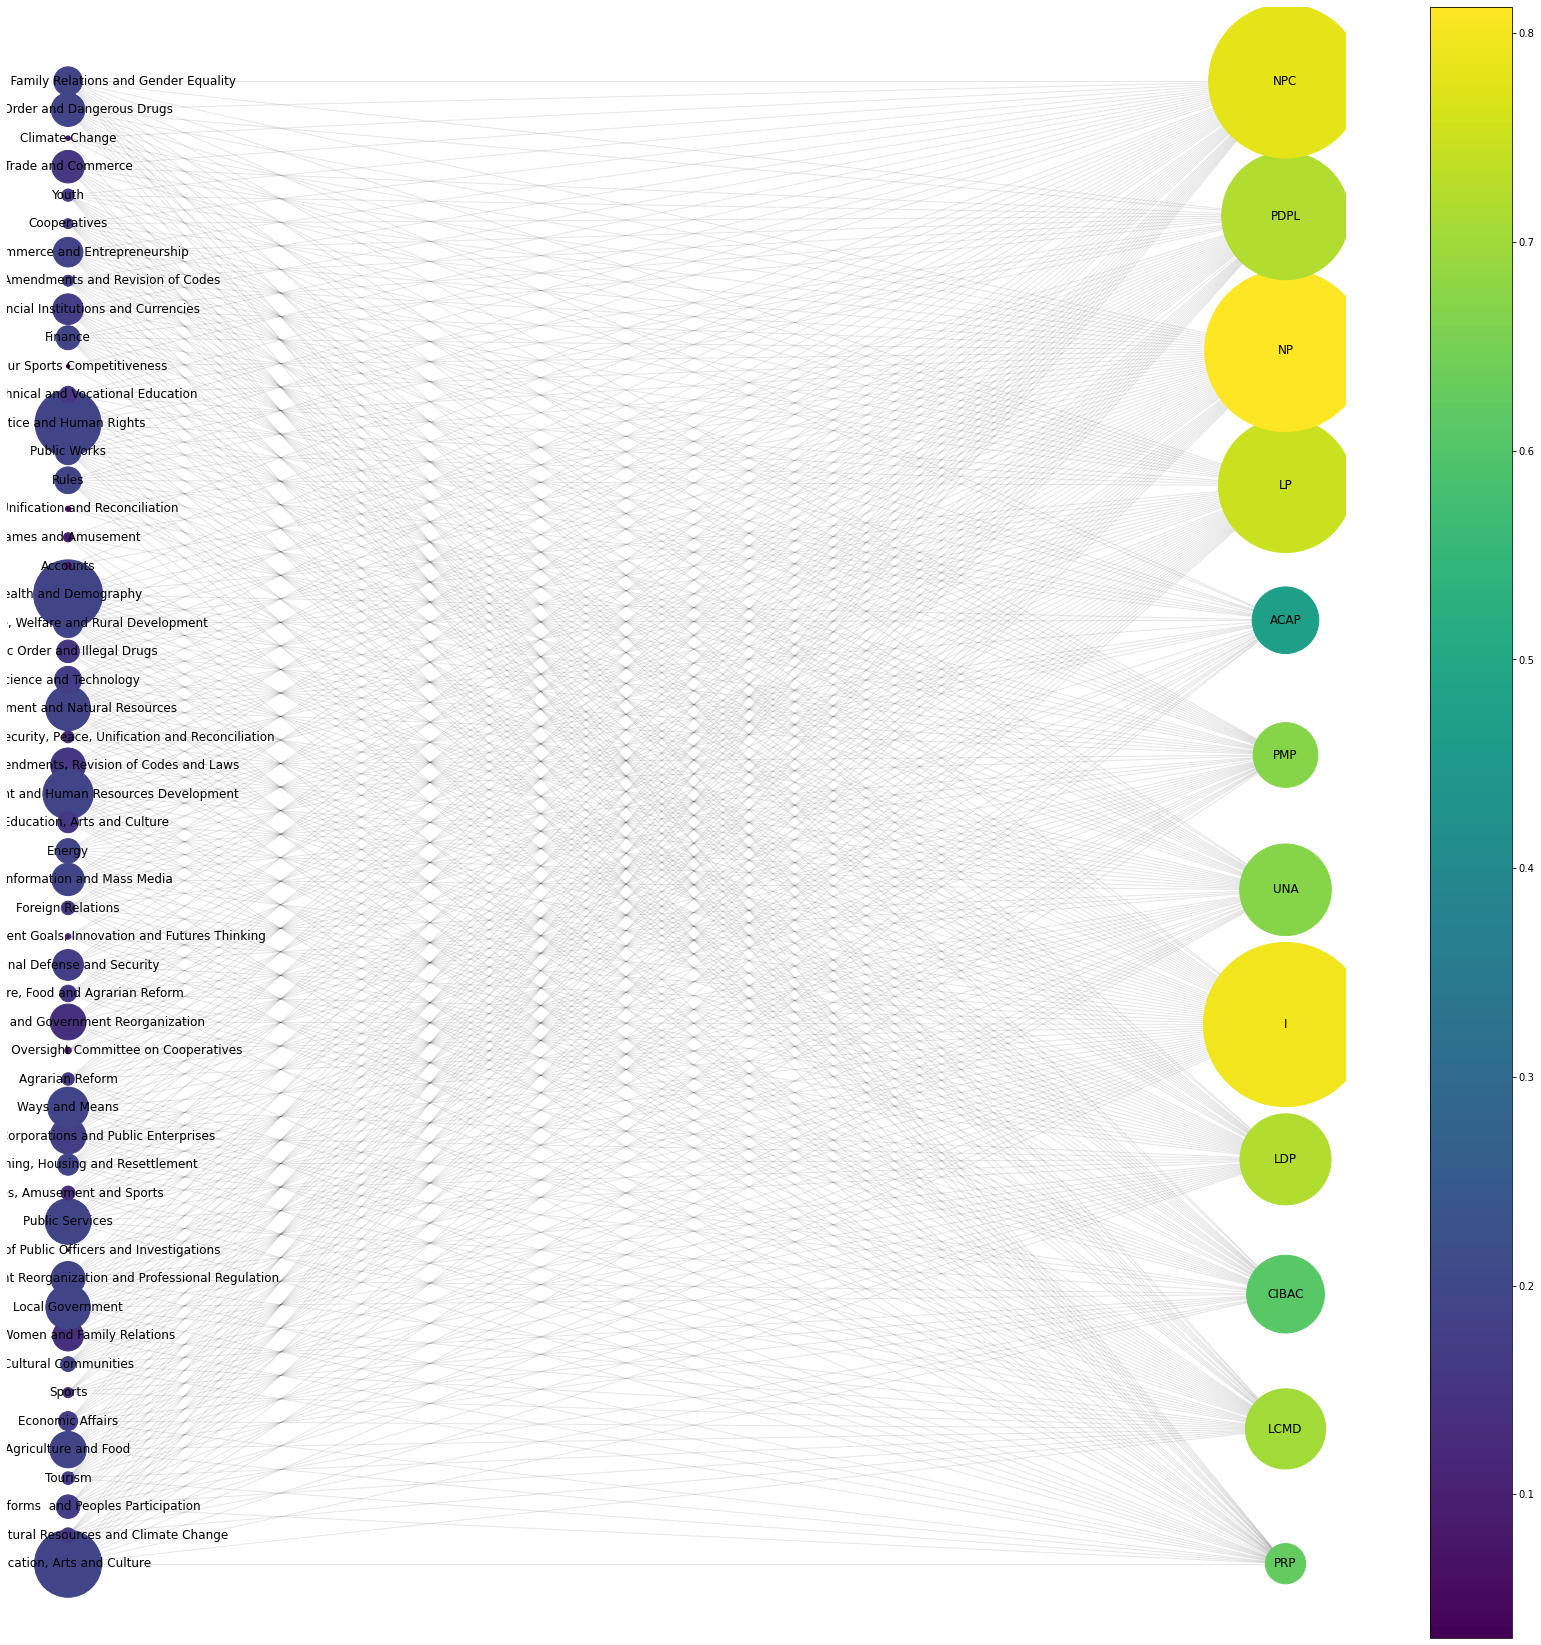

In [82]:
G8 = nx.Graph()
G8.add_nodes_from(list(set(parties)), bipartite=0)

unique_commmittee = [i for i in df.primary_committee.unique() if type(i) != float]
G8.add_nodes_from(unique_commmittee, bipartite=1)
  
df9 = df2.copy()
df9['filed_by'] = df9['filed_by'].replace(sen_party)
edge_list = []
for i in df9.groupby('primary_committee')['filed_by'].apply(set).reset_index().to_numpy():
    for j in i[1]:
        edge_list.append((i[0], j))       
G8.add_edges_from(edge_list)        

s2, n_c = [], []
for i in G8.nodes():
    if i in unique_commmittee:
        s2.append(df.primary_committee.value_counts().to_dict()[i]*3)
    else:
        s2.append(df8.groupby('filed_by')['uniquebill'].sum().to_dict()[i]/2)
    n_c.append(nx.degree_centrality(G8)[i])

pos9 = nx.bipartite_layout(G8, unique_commmittee) 

plt.figure(figsize=(30,30))
plt.axis("off");

nx.draw_networkx_labels(G8, pos=pos9, font_color ='k');
nx.draw_networkx_edges(G8, pos9, alpha=0.1);
nc = nx.draw_networkx_nodes(G8, pos9, node_color=n_c, node_size=s2)
plt.colorbar(nc);

In [166]:
l = df['primary_committee'].value_counts()[:5].index
l

Index(['Health and Demography', 'Education, Arts and Culture',
       'Justice and Human Rights',
       'Labor, Employment and Human Resources Development', 'Public Services'],
      dtype='object')

In [189]:
trend = df[df.primary_committee.apply(lambda x: x in l)].groupby(['congress', 'primary_committee'])['uniquebill'].count().reset_index()

# trend = df.groupby(['congress'])['uniquebill'].count().reset_index()

In [190]:
px.line(trend, x='congress',
        y='uniquebill', color='primary_committee')

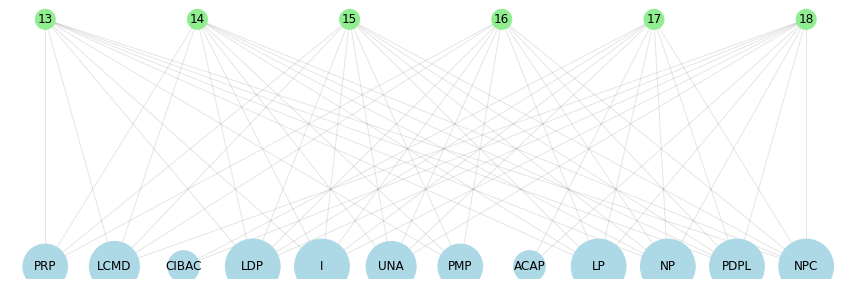

In [85]:
G9 = nx.Graph()
G9.add_nodes_from(parties, bipartite=0)

unique_congress = [i for i in df.congress.unique() if type(i) != float]
G9.add_nodes_from(unique_congress, bipartite=1)

edge_list = []
for i in df9.groupby('congress')['filed_by'].apply(set).reset_index().to_numpy():
    for j in i[1]:
        edge_list.append((i[0], j))      
G9.add_edges_from(edge_list)        

pos10 = nx.bipartite_layout(G9, unique_congress, align='horizontal')

color_map = []
s = []
for x in list(G9.nodes):
    if x not in unique_congress:
        color_map.append('lightblue')
        s.append(df9.groupby('filed_by')['congress'].nunique().to_dict()[x]*500)
    else:
        color_map.append('lightgreen') 
        s.append(400)        

plt.figure(figsize=(15,5))
plt.axis("off");

nx.draw_networkx_nodes(G9, pos=pos10, node_color=color_map, node_size=s)
nx.draw_networkx_labels(G9, pos10, font_color ='k');
nx.draw_networkx_edges(G9, pos10, alpha=0.1);

In [89]:
sen_party

{'Angara; Edgardo J.': 'LDP',
 'Angara; Juan Edgardo "Sonny" M.': 'LDP',
 'Aquino III; Benigno S.': 'LP',
 'Aquino IV; Paolo Benigno "Bam"': 'LP',
 'Arroyo; Joker P.': 'LCMD',
 'Biazon; Rodolfo G.': 'LP',
 'Binay; Maria Lourdes Nancy S.': 'UNA',
 'Cayetano; Alan Peter Companero S.': 'NP',
 'Cayetano; Pia S.': 'NP',
 'De Lima; Leila M.': 'LP',
 'Defensor Santiago; Miriam': 'PRP',
 'Dela Rosa; Ronald "Bato"': 'PDPL',
 'Drilon; Franklin M.': 'LP',
 'Ejercito Estrada; Luisa "Loi" P.': 'PMP',
 'Ejercito-Estrada; Jinggoy P.': 'NPC',
 'Ejercito; Joseph Victor G.': 'PMP',
 'Enrile; Juan Ponce': 'PMP',
 'Escudero; Francis "Chiz" G.': 'I',
 'Flavier; Juan M.': 'LCMD',
 'Gatchalian; Win': 'NPC',
 'Go; Christopher Lawrence T.': 'PDPL',
 'Gordon; Richard J.': 'I',
 'Guingona III; Teofisto "Tg"': 'LP',
 'Honasan II; Gregorio B.': 'UNA',
 'Hontiveros; Risa': 'ACAP',
 'Lacson; Panfilo M.': 'I',
 'Lapid; Manuel "Lito" M.': 'NPC',
 'Legarda; Loren B.': 'NPC',
 'Lim; Alfredo S.': 'PMP',
 'Madrigal; M. A.

In [90]:
df5

filed_by                          filed_by2  uniquebill  \
1         Angara; Edgardo J.                   Arroyo; Joker P.          38   
2         Angara; Edgardo J.                 Biazon; Rodolfo G.          74   
3         Angara; Edgardo J.  Cayetano; Alan Peter Companero S.          14   
4         Angara; Edgardo J.                   Cayetano; Pia S.          91   
5         Angara; Edgardo J.          Defensor Santiago; Miriam         118   
...                      ...                                ...         ...   
1673  Zubiri; Juan Miguel F.        Tolentino; Francis "Tol" N.         276   
1674  Zubiri; Juan Miguel F.      Trillanes; Antonio "Sonny" F.         283   
1675  Zubiri; Juan Miguel F.                   Villanueva; Joel         769   
1676  Zubiri; Juan Miguel F.                 Villar; Cynthia A.         605   
1677  Zubiri; Juan Miguel F.                      Villar; Manny          79   

        weight  
1     0.043871  
2     0.090323  
3     0.012903  
4     0.112258  
5     0.147097  
...        ...  
1673  0.350968  
1674  0.360000  
1675  0.987097  
1676  0.775484  
1677  0.096774  

[1630 rows x 4 columns]

In [171]:
parties_full = ["People's Reform Party", "Pwersa ng Masang Pilipino", "Nacionalista", "Lakas-Christian Muslim Democrats",
 "Nationalist People's Coalition", "Independent", "Laban ng Demokratikong Pilipino",
 "United Nationalist Alliance", "Citizens' Battle Against Corruption", "Liberal Party", 
 "Akbayan Citizens' Action Party", "Partido Demokratikong Pilipino-Laban"]

In [174]:
df10 = df2[['uniquebill', 'filed_by']]
df10['filed_by2'] = df10['filed_by'].replace(sen_party)
df10 = df10.groupby(['filed_by2', 'filed_by'])[['uniquebill']].count().reset_index().sort_values(by='uniquebill', ascending=False)
df10_ = df10.drop_duplicates(subset='filed_by2').reset_index(drop=True)
df10_['Party.'] = parties_full
df10_.columns = ['Party', 'Senator', 'u', 'Party.']
df10_[['Party', 'Party.', 'Senator']]

Party                                Party.  \
0     PRP                 People's Reform Party   
1     PMP             Pwersa ng Masang Pilipino   
2      NP                          Nacionalista   
3    LCMD      Lakas-Christian Muslim Democrats   
4     NPC        Nationalist People's Coalition   
5       I                           Independent   
6     LDP       Laban ng Demokratikong Pilipino   
7     UNA           United Nationalist Alliance   
8   CIBAC   Citizens' Battle Against Corruption   
9      LP                         Liberal Party   
10   ACAP        Akbayan Citizens' Action Party   
11   PDPL  Partido Demokratikong Pilipino-Laban   

                            Senator  
0         Defensor Santiago; Miriam  
1        Ejercito; Joseph Victor G.  
2                     Villar; Manny  
3           Revilla Jr.; Ramon Bong  
4                 Legarda; Loren B.  
5       Escudero; Francis "Chiz" G.  
6   Angara; Juan Edgardo "Sonny" M.  
7     Binay; Maria Lourdes Nancy S.  
8                  Villanueva; Joel  
9    Aquino IV; Paolo Benigno "Bam"  
10                 Hontiveros; Risa  
11        Pimentel Jr.; Aquilino Q.

In [250]:
df.primary_committee.unique()

array(['Health and Demography',
       'Constitutional Amendments, Revision of Codes and Laws',
       'Government Corporations and Public Enterprises', 'Ways and Means',
       'Environment and Natural Resources', 'Energy', 'Agrarian Reform',
       'Youth, Women and Family Relations', 'Agriculture and Food',
       'Public Services', 'Public Order and Illegal Drugs',
       'Banks, Financial Institutions and Currencies',
       'Justice and Human Rights', 'Cultural Communities', 'Finance',
       'Education, Arts and Culture',
       'Civil Service and Government Reorganization',
       'Trade and Commerce',
       'Social Justice, Welfare and Rural Development', 'Public Works',
       'Labor, Employment and Human Resources Development',
       'National Defense and Security', 'Economic Affairs',
       'Public Information and Mass Media', 'Games, Amusement and Sports',
       'Local Government', 'Foreign Relations', 'Science and Technology',
       'Urban Planning, Housing and Reset

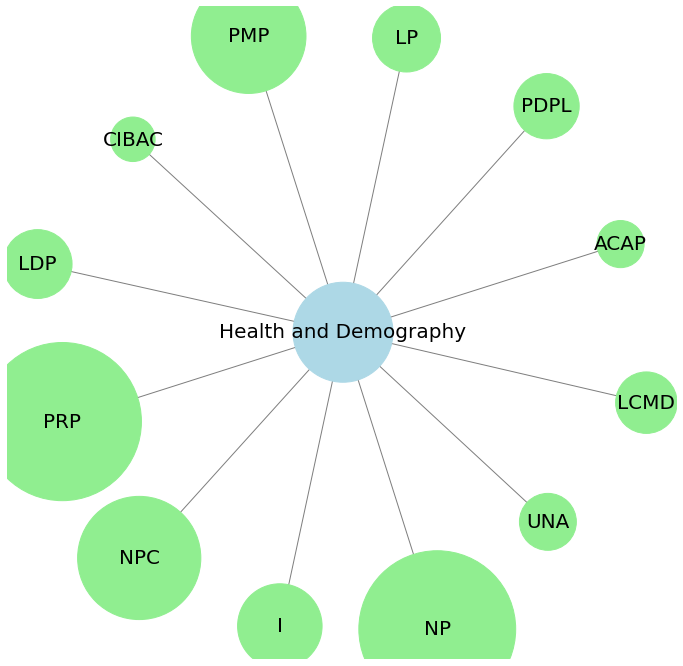

In [326]:
df_com_par = df9.groupby(['primary_committee', 'filed_by'])['uniquebill'].count().to_frame().reset_index()
df_com_par

sizes = Counter(df_com_par.filed_by).most_common()

scaler = MinMaxScaler()
s_scaled = (scaler.fit_transform(np.array([i[1] for i in sizes]).reshape(-1, 1))+0.001).flatten()


commitee_ = 'Health'
# df_com_sub = df_com_par[df_com_par['primary_committee'] == commitee_]
df_com_sub = df_com_par[df_com_par['primary_committee'].agg(lambda x: commitee_ in x)]

# scaler = MinMaxScaler()
# for_sizes = list(np.array(df_com_sub.uniquebill))
# s_scaled = (scaler.fit_transform(np.array(for_sizes).reshape(-1, 1))/0.00005).flatten()
# df_com_sub['weight'] = s_scaled

# s_scaled = [i for i in s_scaled]
# s_scaled.insert(0, np.mean(s_scaled))

s_scaled = [df_com_sub.groupby('filed_by')['uniquebill'].sum().to_dict()[i]*60 if i in set(parties) else 10000 for i in G_com_party.nodes]

G_com_party = nx.from_pandas_edgelist(df_com_sub, 'primary_committee', 'filed_by', edge_attr='uniquebill')
pos1 = nx.spring_layout(G_com_party)    
plt.figure(figsize=(12,12));
plt.axis("off");
nx.draw_networkx_nodes(G_com_party, pos1, node_size=s_scaled, 
                       node_color=['lightblue' if commitee_ in i else 'lightgreen' for i in G_com_party.nodes]);
nx.draw_networkx_edges(G_com_party, pos1, alpha=0.500);
nx.draw_networkx_labels(G_com_party, pos1, font_color ='k', font_size=20);

In [310]:
df_com_sub

Empty DataFrame
Columns: [primary_committee, filed_by, uniquebill]
Index: []

In [300]:
s_scaled = [df_com_sub.groupby('filed_by')['uniquebill'].sum().to_dict()[i] if i in set(parties) else 500 for i in G_com_party.nodes]

[500, 20, 41, 191, 114, 144, 101, 488, 261, 64, 49, 500, 195, 334]

In [292]:
df_com_sub[['filed_by', 'weight']].set_index('filed_by').to_dict()

{'weight': {'ACAP': 89.48545861297542,
  'CIBAC': 760.6263982102907,
  'I': 6711.409395973154,
  'LCMD': 3713.6465324384785,
  'LDP': 5324.384787472036,
  'LP': 3713.6465324384785,
  'NP': 20000.0,
  'NPC': 9664.429530201342,
  'PDPL': 984.3400447427291,
  'UNA': 984.3400447427291,
  'PMP': 8322.14765100671,
  'PRP': 14541.3870246085}}